# Progetto machine learning

## Obiettivi
Obiettivo del progetto è la sperimentazione di vari modelli di classificazione in grado di riconoscere generi musicali. Lo sviluppo del progetto è suddiviso in due sezioni:
- Nella prima sezione si addestreranno e testeranno modelli sulla base di un insieme di dati che sono stati pre-calcolati e offerti da Free Music Archive (FMA). FMA è un archivio "open" che offre gratuitamente accesso ad una vasta gamma di audio appartenenti a vari generi.

- La seconda sezione si prefigge di effettuare una classificazione di un brano musicale a partire dal suo spettrogramma. Quindi in questa sezione verrà creato un nuovo dataset a partire dagli audio scaricati da FMA. Gli audio scaricati sono infatti convertiti in immagini ,che rappresentano lo spettrogramma dell'audio, e che verranno successivamente utilizzate per addestrare e testare una rete convoluzionale. Di conseguenza non si farà uso di dati già pre-calcolati, ma verranno generati da zero.

## Prima sezione
In questa prima sezione la sperimentazione ha come obiettivo quello di confrontare tre modelli di classifiazione:
1. SVM
2. Gaussian Naive Bayes
3. Random Forest

Ogni modello sarà soggetto ad una model selection per individuare i parametri che massimizzano l'accuratezza. Il confronto dei modelli si baserà invece sull'analisi di:
1. **Matrice di confusione**. Attraverso la matrice di confusione è possibile capire quali sono i generi che un determinato classificatore riesce ad individuare più facilmente e quali sono gli errori più comuni che vengono commessi. 
2. **Distrubuzione di probabilità**. L'idea è quella di rappresentare la distribuzione di probabilità di ogni classe su un piano bidimensionale, per avere un'idea di come il classificatore ha partizionato i dati di input a seguito della fase di training.
3. **Curva di apprendimento**. Mostra come le prestazioni del modello predittivo  migliorano man mano che viene eseguito l'addestramento utilizzando un numero crescente di dati. Può aiutare a trovare problemi di overfitting e underfitting.


Per la realizzazione del progetto si importano una serie di librerie e funzioni utili.

In [44]:

%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.decomposition, sklearn.svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import utils
import dotenv
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve
import multiprocessing.sharedctypes as sharedctypes
import os.path
import ast
import warnings
import matplotlib 
warnings.filterwarnings('ignore')


plt.rcParams['figure.figsize'] = (17, 5)

NB_AUDIO_SAMPLES = 1321967
SAMPLING_RATE = 44100

dotenv.load_dotenv(dotenv.find_dotenv())

def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.

    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'

    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')


def plot_matrix_confusion(clf,X_test,y_test,title):
    y_pred = clf.predict(X_test)

    # Calcolo della matrice di confusione
    cm = confusion_matrix(y_test, y_pred)

    # Definizione delle etichette delle classi
    class_labels = np.unique(np.concatenate((y_test, y_pred)))

    # Plot della matrice di confusione
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)

    # Aggiunta dei valori all'interno della matrice di confusione
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

    plt.xlabel('Etichette Predette')
    plt.xticks(rotation=90)

    plt.ylabel('Etichette Vere')
    plt.tight_layout()
    plt.show()

def plot_ditribution(clf,X_train,tracks,features):
    f, axarr = plt.subplots(8,2,figsize=(16, 32),sharex=True, sharey=True)

    all_pos_to_plot = [[0,0],[1,0],[2,0],[3,0],[4,0],[5,0],[6,0],[7,0]]

    pc = skl.decomposition.PCA(n_components=2)

    for genre , genre_name in enumerate(clf.classes_):
        small = tracks['set', 'subset'] <= 'small'
        genre1 = tracks['track', 'genre_top'] == clf.classes_[genre]

        X = features.loc[small & (genre1)]
        X.columns = X.columns.to_flat_index()
        X.columns = [str(elem) for elem in X.columns]
        
        value = pc.fit_transform(X_train)
        X=pc.transform(X)

        pos_to_plot = all_pos_to_plot[genre]
        axarr[pos_to_plot[0]][pos_to_plot[1]].scatter(X[:,0], X[:,1] ,alpha=0.5)

        u = np.linspace(value[:,0].min(), value[:,0].max(), 100)
        v = np.linspace(value[:,1].min(), value[:,1].max(), 100)
        z = np.zeros((len(u), len(v)))
        y0 = np.zeros((len(u), len(v)))


        for i in range(len(u)):
            for j in range(len(v)):
                data = []
                temp = []
                temp.append(u[i])
                temp.append(v[j])
                data.append(temp.copy())
                to_pred= pc.inverse_transform(data)
                pr = clf.predict_proba(to_pred)
                y0[i,j] = pr[0][genre]


        u, v = np.meshgrid(u, v)
        mappable = axarr[pos_to_plot[0]][pos_to_plot[1]].imshow(y0, origin='lower', extent=(value[:,0].min(), value[:,0].max(), value[:,1].min(), value[:,1].max()), alpha=.5)
        mappable2= axarr[pos_to_plot[0]][pos_to_plot[1]+1].imshow(y0, origin='lower', extent=(value[:,0].min(), value[:,0].max(), value[:,1].min(), value[:,1].max()), alpha=.5)
        axarr[pos_to_plot[0]][pos_to_plot[1]].set_title(clf.classes_[genre])
        axarr[pos_to_plot[0]][pos_to_plot[1]+1].set_title(clf.classes_[genre])

        f.colorbar(mappable)
        f.colorbar(mappable2)



def plot_ditribution_single_class(clf,X_train,tracks,features,plotter,f,class_name,genre,clf_name):
    
    pc = skl.decomposition.PCA(n_components=2)
    value = pc.fit_transform(X_train)

    small = tracks['set', 'subset'] <= 'small'
    genre1 = tracks['track', 'genre_top'] == class_name

    X = features.loc[small & (genre1)]
    X.columns = X.columns.to_flat_index()
    X.columns = [str(elem) for elem in X.columns]
    
    X=pc.transform(X)

    u = np.linspace(value[:,0].min(), value[:,0].max(), 100)
    v = np.linspace(value[:,1].min(), value[:,1].max(), 100)
    z = np.zeros((len(u), len(v)))
    y0 = np.zeros((len(u), len(v)))

    for i in range(len(u)):
        for j in range(len(v)):
            data = []
            temp = []
            temp.append(u[i])
            temp.append(v[j])
            data.append(temp.copy())
            to_pred= pc.inverse_transform(data)
            pr = clf.predict_proba(to_pred)
            y0[i,j] = pr[0][genre]


    u, v = np.meshgrid(u, v)
    mappable = plotter.imshow(y0, origin='lower', extent=(value[:,0].min(), value[:,0].max(), value[:,1].min(), value[:,1].max()), alpha=.5)
    plotter.set_title(clf_name)

    f.colorbar(mappable)


def plot_learning_curve(clf,tracks,features):
    small = tracks['set', 'subset'] <= 'small'
    train = tracks['set', 'split'] == 'training'
    val = tracks['set', 'split'] == 'validation'

    y = tracks.loc[small & (train | val), ('track', 'genre_top')]
    X = features.loc[small & (train | val)]

    # Calcola la curva di apprendimento
    train_sizes, train_scores, val_scores = learning_curve(clf, X, y, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9], cv=5)

    # Calcola la media e la deviazione standard degli score
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Grafica la curva di apprendimento
    plt.figure()
    plt.title("Curva di Apprendimento")
    plt.xlabel("Dimensione del Training Set")
    plt.ylabel("Score")
    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="b", label="Validation score")
    plt.legend(loc="best")
    plt.show()

    

## Dati
I dati scaricati da FMA e utilizzati per questo progetto sono raccolti in due csv che verrano utilizzati in maniera combinata:
- tracks.csv : mantiene informazioni relative ai metadati degli audio.
- features.csv : mantiene un set di features pre-calcolate e che descrivono da un punto di vista statistico gli audio. 

Combinando le informazioni provenienti da entrambi i csv è possibile ricavare un dataset completo con featutures e valori target.

In [2]:

# caricamento features e target
tracks = utils.load('data/fma_metadata/tracks.csv')
features = utils.load('data/fma_metadata/features.csv')

tracks.shape, features.shape

((106574, 52), (106574, 518))

Nel file track.csv sono mantenute informaizioni relative :
- **all'album di appartenenza** di un audio. In particolare viene specificato la data di creazione dell'album, il produttore, il titolo, il tipo,commenti etc.
- al suo **autore**. In particolare viene specificata la biografia, il suo sito web, la sua pagina wikipedia etc.
- informazioni generiche sull'**audio**. In particolare viene specificato la lingua, la licenza , il titolo, il bit rate, il genere.. etc.

Tutti i nomi delle features sono mostrati in basso. Osservando questi attributi appare evidente che si tratti solo di informazioni di contorno, che quasi sicuramente non sono utili ad un classificatore per effettuare delle predizioni. Di queste informazioni gli unici dati di interesse sono l'id dell'audio e il suo genere. Queste informazioni infatti combinate ai dati presenti in features.csv permettono la creazione di un dataset completo in cui è possibile associare a delle entry un target specifico. Tutti gli altri dati di questo csv non verranno presi in considerazione.


In [3]:
print(tracks.columns)

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          


Il file features.csv contiene informazioni relative a 10 features calcolate tramite librosa. In particolare per ogni feature sono mantenute statistiche come media, varianza , curtosi, massimo e minimo. Le 10 features sono:
- **spectral_bandwidth**: La larghezza di banda spettrale si riferisce all'estensione di frequenza occupata da un segnale o da una componente di frequenza all'interno dello spettro. Indica quanto spazio occupa il segnale nello spettro delle frequenze.
- **spectral_centroid**: centro di massa dello spettro.
- **spectral_contrast** : Lo spectral contrast (contrasto spettrale) è una misura che descrive la differenza di energia tra i picchi spettrali e i valori di fondo dello spettro di un segnale audio. 
- **spectral_rolloff** : Spectral rolloff (rolloff spettrale) è una misura utilizzata per descrivere la pendenza o la frequenza di taglio superiore dello spettro di un segnale audio. Indica la frequenza al di sopra della quale si trova una certa percentuale di energia spettrale totale.
- **chroma_cens** :  Chroma Energy Normalized (CENS) è una rappresentazione utilizzata per l'analisi degli spettri musicali. È una variante del Chroma Energy Normalization (CEN), che mira a fornire una rappresentazione robusta delle caratteristiche tonali di un brano musicale.
- **chroma_cqt** : Il Constant-Q Chromagram è una rappresentazione spettrale di un segnale audio che cattura le informazioni sulle componenti tonali in modo simile al Chroma Energy Normalized (CENS), ma utilizza una trasformata di Fourier a tempo breve a risoluzione costante (Constant-Q Transform) anziché la tradizionale STFT.
La trasformata di Fourier a tempo breve (STFT) viene generalmente utilizzata per ottenere la rappresentazione spettrale di un segnale audio, ma ha una risoluzione costante in termini di frequenza. Ciò significa che la distanza tra le frequenze è costante in tutta la scala dello spettro audio. Tuttavia, l'orecchio umano percepisce le frequenze in modo logaritmico, il che significa che le differenze tra le frequenze percepibili non sono costanti, ma si espandono in modo logaritmico.
Per affrontare questa differenza di percezione è utilizzata la trasformata di Fourier a tempo breve a risoluzione costante (Constant-Q Transform). Questa trasformata fornisce una risoluzione in frequenza che aumenta in modo logaritmico, in modo che le frequenze più basse abbiano una maggiore risoluzione rispetto alle frequenze più alte.
- **tonnetz** : Il tonnetz è utile per visualizzare e comprendere le relazioni tonali e armoniche. Può aiutare a identificare le progressioni di accordi, le modulazioni tonali e le relazioni di tonalità in una composizione musicale. 
- **zcr**: Zero-crossing rate (tasso di attraversamento dello zero) è una misura utilizzata per descrivere la frequenza con cui un segnale audio attraversa lo zero in un determinato intervallo di tempo. Indica il numero di volte in cui la forma d'onda del segnale cambia di segno da positivo a negativo o viceversa.
- **mfcc**: mel-frequency cepstrum è una rappresentazione dello spettro di potenza a breve termine di un suono, basato su una trasformata lineare del coseno di uno spettro di potenza logaritmica su una scala di frequenza mel non lineare .
- **rmse** 
- **chroma_stft** 


In [4]:
print(features.columns[0::6])

MultiIndex([(       'chroma_cens', 'kurtosis', '01'),
            (       'chroma_cens', 'kurtosis', '07'),
            (       'chroma_cens',      'max', '01'),
            (       'chroma_cens',      'max', '07'),
            (       'chroma_cens',     'mean', '01'),
            (       'chroma_cens',     'mean', '07'),
            (       'chroma_cens',   'median', '01'),
            (       'chroma_cens',   'median', '07'),
            (       'chroma_cens',      'min', '01'),
            (       'chroma_cens',      'min', '07'),
            (       'chroma_cens',     'skew', '01'),
            (       'chroma_cens',     'skew', '07'),
            (       'chroma_cens',      'std', '01'),
            (       'chroma_cens',      'std', '07'),
            (        'chroma_cqt', 'kurtosis', '01'),
            (        'chroma_cqt', 'kurtosis', '07'),
            (        'chroma_cqt',      'max', '01'),
            (        'chroma_cqt',      'max', '07'),
            (        'chroma

Per gli scopi di questo progetto i dati a disposizione sono stati partizionati per ottenere un dataset per la fase di training, uno per la fase di validazione e  uno invece per la fase di test. La fase di validazione verrà sfruttata per realizzare un minimo di model selection.

In [46]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
y_val = tracks.loc[small & val, ('track', 'genre_top')]

X_train = features.loc[small & train]
X_test = features.loc[small & test ]
X_val = features.loc[small & val]

print('{} training examples, {} testing examples, {} validation examples'.format(y_train.size, y_test.size,y_val.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))



6400 training examples, 800 testing examples, 800 validation examples
518 features, 8 classes


Il dataset si compone di 518 features, 8000 entry e 8 generi musicali.In particolare le 8 classi sono perfettamente bilanciate. Ci sono esattamente 1000 entry per ogni classe.

<BarContainer object of 8 artists>

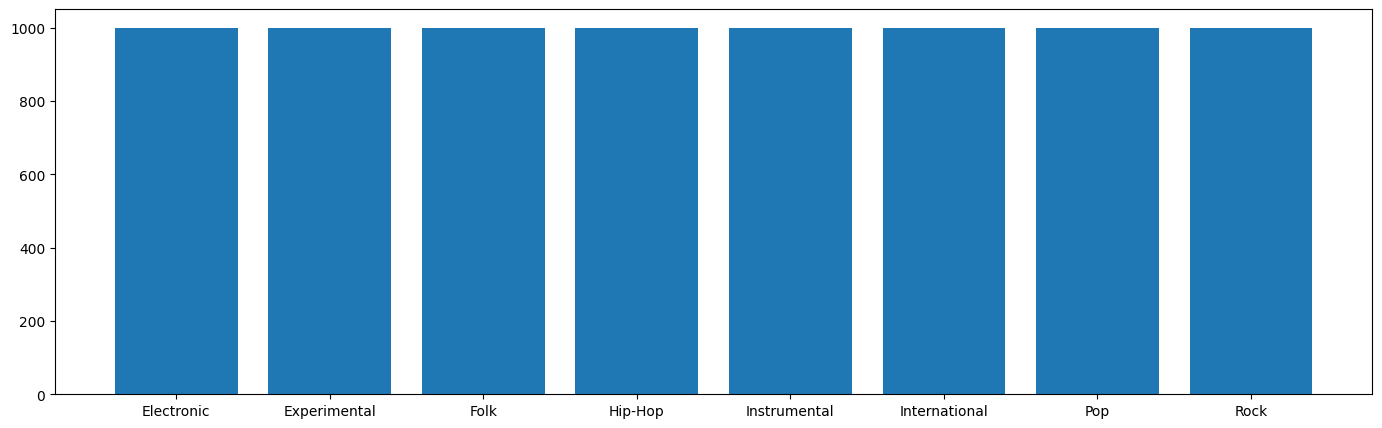

In [6]:
small = tracks['set', 'subset'] <= 'small'
all_genre = ['Electronic', 'Experimental', 'Folk' ,'Hip-Hop' ,'Instrumental','International' ,'Pop', 'Rock']
num_genre = []

for pos ,genre_name in enumerate(all_genre):
    genre = tracks['track', 'genre_top'] == genre_name
    X = features.loc[small & (genre)]
    num_genre.append(len(X))

plt.bar(all_genre,num_genre)

Nei csv i dati sono organizzati in maniera gerarchica. Le varie colonne che compongono il dataset sono modellate da python come "multi index". Per cui se si vuole accedere ad una riga del dataset bisogna specificare una tupla di elementi che corrispondono alla feature di interesse e alla statistica calcolata su quella specifica feature(esempio : media , varianza , massimo , minimo, etc,). Avere un dataset organizzato in questo modo può rivelarsi molto scomodo soprattutto nella generazione dei grafici. Con il pezzo di codice seguente viene effettuato un appiattimento della struttura gerarchica in modo che il nome di una colonna venga modellato come una stringa che indica la coppia "feature-statistica". 

In [47]:

X_train.columns = X_train.columns.to_flat_index()
X_train.columns = [str(elem) for elem in X_train.columns]

X_test.columns = X_test.columns.to_flat_index()
X_test.columns = [str(elem) for elem in X_test.columns]

X_val.columns = X_val.columns.to_flat_index()
X_val.columns = [str(elem) for elem in X_val.columns]

for i in range(0,len(X_train.columns),20):
    print(X_train.columns[i])

('chroma_cens', 'kurtosis', '01')
('chroma_cens', 'max', '09')
('chroma_cens', 'median', '05')
('chroma_cens', 'skew', '01')
('chroma_cens', 'std', '09')
('chroma_cqt', 'max', '05')
('chroma_cqt', 'median', '01')
('chroma_cqt', 'min', '09')
('chroma_cqt', 'std', '05')
('chroma_stft', 'max', '01')
('chroma_stft', 'mean', '09')
('chroma_stft', 'min', '05')
('chroma_stft', 'std', '01')
('mfcc', 'kurtosis', '09')
('mfcc', 'max', '09')
('mfcc', 'mean', '09')
('mfcc', 'median', '09')
('mfcc', 'min', '09')
('mfcc', 'skew', '09')
('mfcc', 'std', '09')
('spectral_bandwidth', 'max', '01')
('spectral_contrast', 'max', '01')
('spectral_contrast', 'median', '07')
('spectral_contrast', 'std', '06')
('tonnetz', 'max', '06')
('tonnetz', 'skew', '02')


## Rappresentazione dei dati
Per avere un idea più chiara dei dati a disposizione è possibile effettuare un minimo di analisi statistica e graficare i dati stessi su un piano bidimensionale. Per rappresentare graficamente i dati è possibili applicare una riduzione di dimensionalità utilizzando la PCA. Si ricordi che il dataset originale ha 518 entry , per cui cercare di proiettare un punto in uno spazio a 518 dimensioni in uno a 2, comporta inevitabilmente una grande perdita di informazioni. Tuttavia questo non è un grande problema, infatti l'addestramento dei modelli di classificazione avverrà comunque con il dataset completo, la riduzione di dimensionalità in questo caso ha solo l'obiettivo di mostrare i dati. Di seguito è riportata la rappresentazione delle entry del dataset suddivisa per genere. Si può notare da questa prima immagine come i punti delle varie classi siano molto simili tra loro e per la maggior parte sono proiettati tutti nella stessa regione del piano.

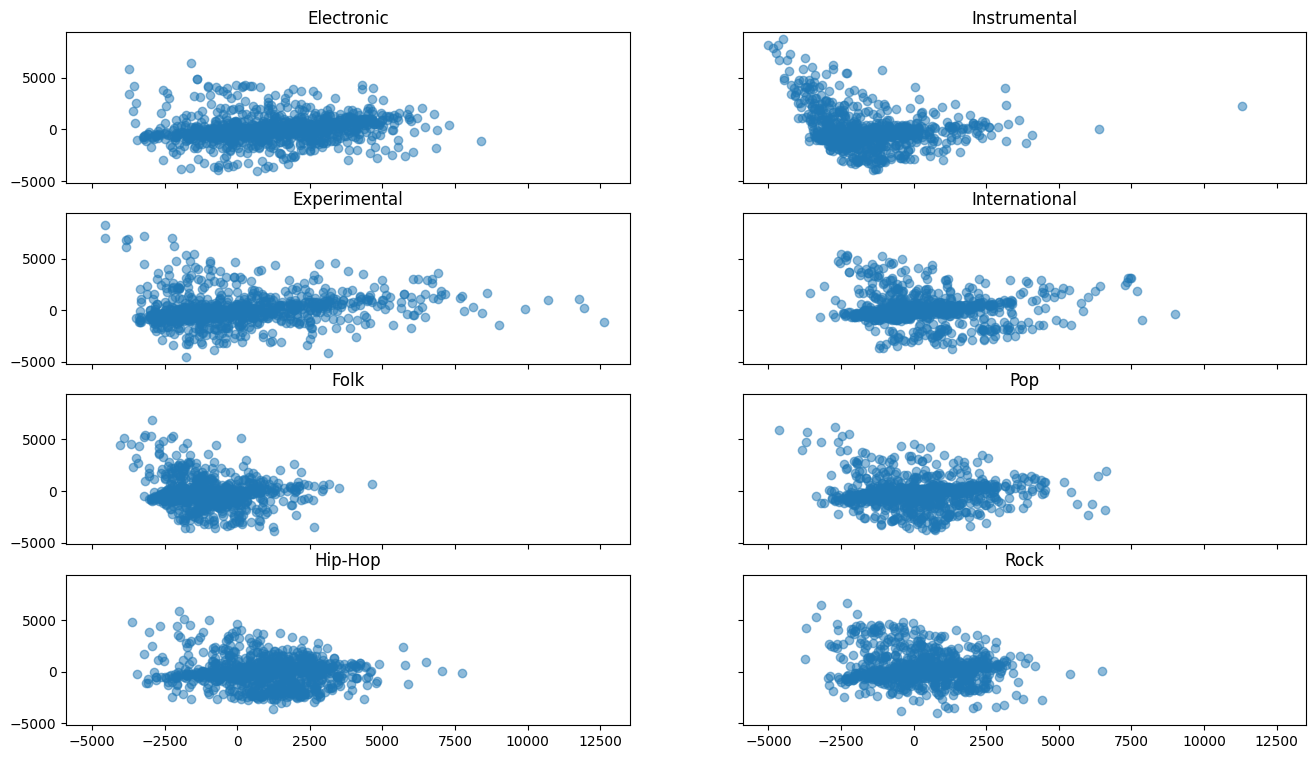

In [8]:
small = tracks['set', 'subset'] <= 'small'
f, axarr = plt.subplots(4,2,figsize=(16, 9),sharex=True, sharey=True)

all_pos_to_plot = [[0,0],[1,0],[2,0],[3,0],[0,1],[1,1],[2,1],[3,1]]
all_genre = ['Electronic', 'Experimental', 'Folk' ,'Hip-Hop' ,'Instrumental','International' ,'Pop', 'Rock']


#Applico riduzione dimensionalità dei dati di training
Xtot = features.loc[small]
pca = skl.decomposition.PCA(n_components=2)
pca.fit_transform(Xtot)

#Filtro il dataset per classe e lo rappresento su un piano bidimensionale
for pos ,genre_name in enumerate(all_genre):
    genre = tracks['track', 'genre_top'] == genre_name
    X = features.loc[small & (genre)]
    X = pca.transform(X)

    pos_to_plot = all_pos_to_plot[pos]
    axarr[pos_to_plot[0]][pos_to_plot[1]].scatter( X[:,0], X[:,1], alpha=0.5)
    axarr[pos_to_plot[0]][pos_to_plot[1]].set_title(genre_name)




 Rappresentare i dati su uno spazio bidimensionale ha come obiettivo anche quello di verificare se è possibile individuare una partizione dei punti. L'immagine seguente mostra la rappresentazione di coppie di generi a confronto. Si può notare come per quasi tutte le coppie i generi appaiano poco separati e tendono quasi a sovrapporsi. Solo la coppia Instrumental - Hip-Hop è più separabile delle altre.  Invece la coppia Pop-Rock è quasi perfettamente sovrapposte tra di loro. Questo potrebbe far pensare che i modelli di classificazione possano fare molta fatica ad distinguere questi due generi. 

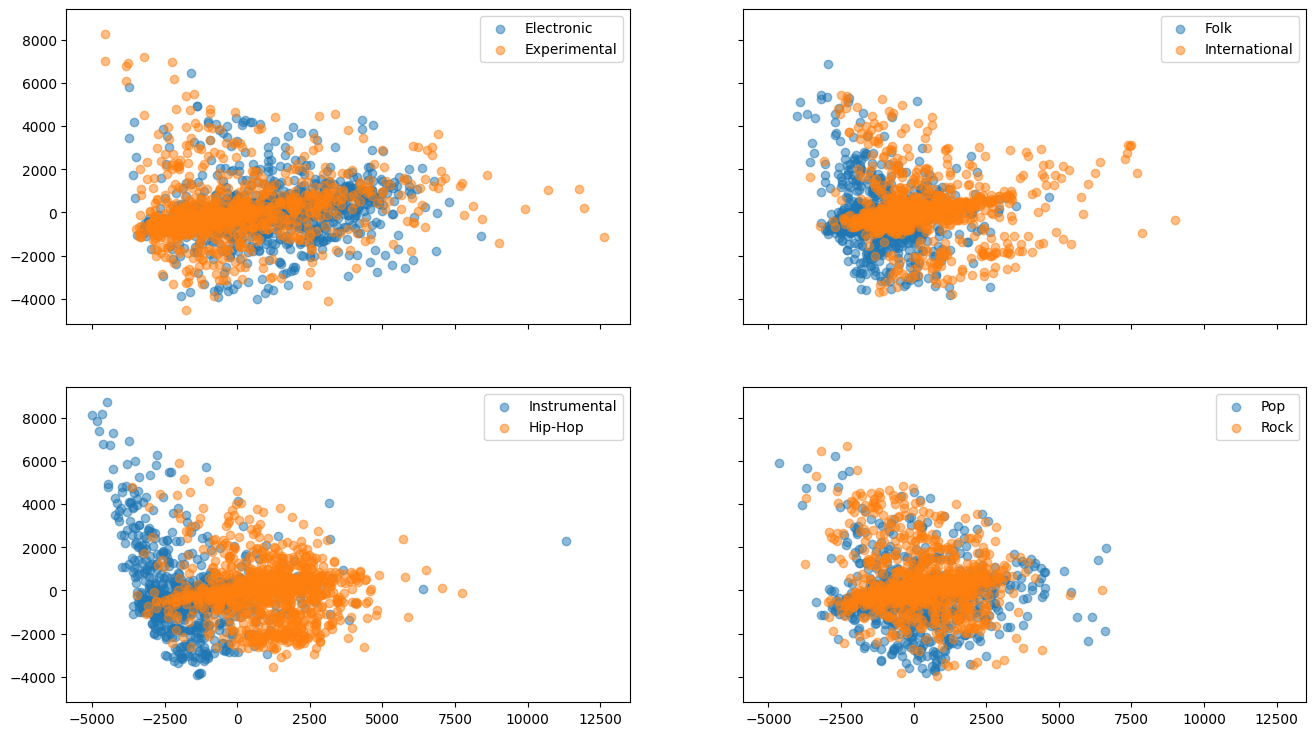

In [9]:
small = tracks['set', 'subset'] <= 'small'
all_pos_to_plot = [[0,0],[1,0],[0,1],[1,1]]
all_duo_genre = [['Electronic', 'Experimental'] , ['Instrumental' ,'Hip-Hop'] ,['Folk','International'] ,['Pop', 'Rock']]

#Applico riduzione dimensionalità dei dati di training
Xtot = features.loc[small]
pca = skl.decomposition.PCA(n_components=2)
pca.fit_transform(Xtot)

f, axarr = plt.subplots(2,2,figsize=(16, 9),sharex=True, sharey=True)

#Scorro le coppie di classi che voglio rappresentare nello stesso grafico
for pos ,duo_genre in enumerate(all_duo_genre):

    genre1 = tracks['track', 'genre_top'] == duo_genre[0]
    genre2 = tracks['track', 'genre_top'] == duo_genre[1]
 
    X = features.loc[small & (genre1)]
    X = pca.transform(X)

    X2 = features.loc[small & (genre2)]
    X2 = pca.transform(X2)

    pos_to_plot = all_pos_to_plot[pos]
    axarr[pos_to_plot[0]][pos_to_plot[1]].scatter(X[:,0], X[:,1],alpha=0.5, label=duo_genre[0])
    axarr[pos_to_plot[0]][pos_to_plot[1]].scatter(X2[:,0], X2[:,1], alpha=0.5, label=duo_genre[1])
    axarr[pos_to_plot[0]][pos_to_plot[1]].legend()
    


Si continua con l'analisi dei dati effettuando delle operazioni più dettagliate. I grafici seguenti cercano di mettere a fuoco le caratteristiche delle features in base alla classe di appartenenza. Se le features tendono ad avere caratterizzazioni diverse per ogni classe è piu semplice per un predittore ottenere prestazoni migliori. In particolare per effettuare queste analisi si vanno a cercare le 20 features più significative. La ricerca delle features migliori si basa sul concetto di varianza. Le features che hanno varianza maggiore sono le più significativa.

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=20)

# Applica la selezione delle feature al dataset
X_new = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]


Dopo aver individuato le 20 features più significative è possibile graficare la distribuzione della più significativa , e differenziare questa distribizione per classe di appartenenza. Quello che si può notare è che effettivamente le distribuzioni sono leggermente diverse tra loro. Hanno tutte un andamento a campana, tuttavia alcune hanno una campana piu stretta(Hip-hop) altre una piu larga(Instrumental). Allo stesso modo il valore centrale della campana è diverso da genere a genere.

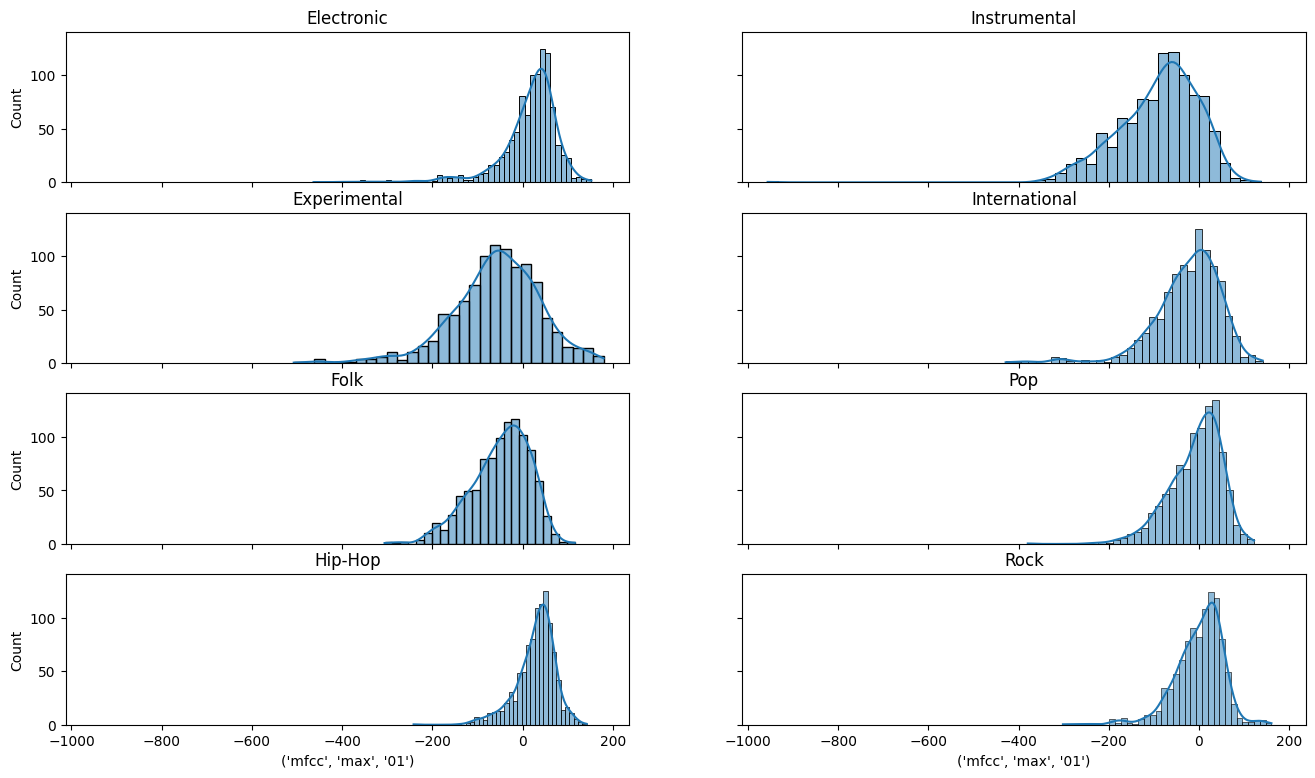

In [11]:
import seaborn as sns


small = tracks['set', 'subset'] <= 'small'
f, axarr = plt.subplots(4,2,figsize=(16, 9),sharex=True, sharey=True)
all_pos_to_plot = [[0,0],[1,0],[2,0],[3,0],[0,1],[1,1],[2,1],[3,1]]
all_genre = ['Electronic', 'Experimental', 'Folk' ,'Hip-Hop' ,'Instrumental','International' ,'Pop', 'Rock']

#Filtro il dataset per ogni classe 
for pos ,genre_name in enumerate(all_genre):
    genre = tracks['track', 'genre_top'] == genre_name

    X = features.loc[small & (genre)]
    X.columns = X_train.columns.to_flat_index()
    X.columns = [str(elem) for elem in X_train.columns]

    pos_to_plot = all_pos_to_plot[pos]

    #Rappresento distribuzione della feature più significativa per ogni classe
    sns.histplot(data=X, x=selected_features[0], kde=True, ax=axarr[pos_to_plot[0]][pos_to_plot[1]])
    axarr[pos_to_plot[0]][pos_to_plot[1]].set_title(genre_name)


L'analisi continua mostrando come le due features più rilevanti sono congiuntamente connesse tra loro. Quello che si può notare è che le features hanno una distribuzione a campana nello spazio uni/bi - dimensionale. Poichè le features hanno tutte una distribuzione a campana si potrebbe già pensare che il classificatore Gaussian naive Bayes possa ottenere delle prestazioni migliori, in quanto la distribuzione gaussiana può essere un ottima approssimazioni per la distrubuzioni delle features.

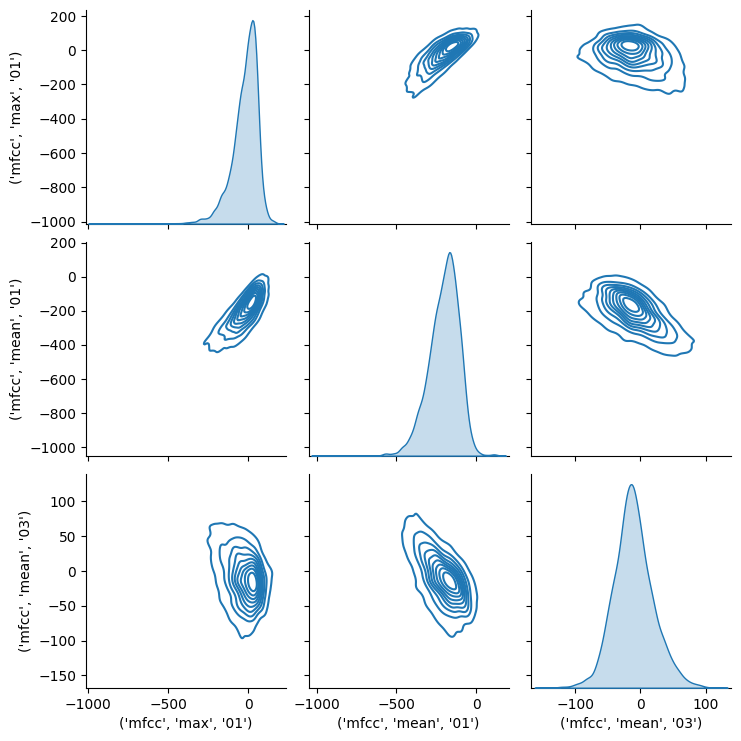

In [12]:

df = pd.DataFrame(X_new,columns=selected_features)
sns.pairplot(data=df, kind="kde",vars=selected_features[:3])

Infine è mostrata anche una matrice di correlazione per vedere come tutte le features sono collegate tra loro. Si può notare che in generale non c'è una fortissima correlazione se non per alcune coppie di features. Si osserva una forte correlazione ad esempio per le features che descrivono un audio nel dominio della frequenza come spectral rolloff , spectral bandwidt, spectral centroid. Il fatto che siano così correlate potrebbe far pensare che siano features portatrici della stessa informazione , e che quindi non sia utilissimo utilizzare tutti questi attributi nella fase di addestramento del modello.

<Axes: >

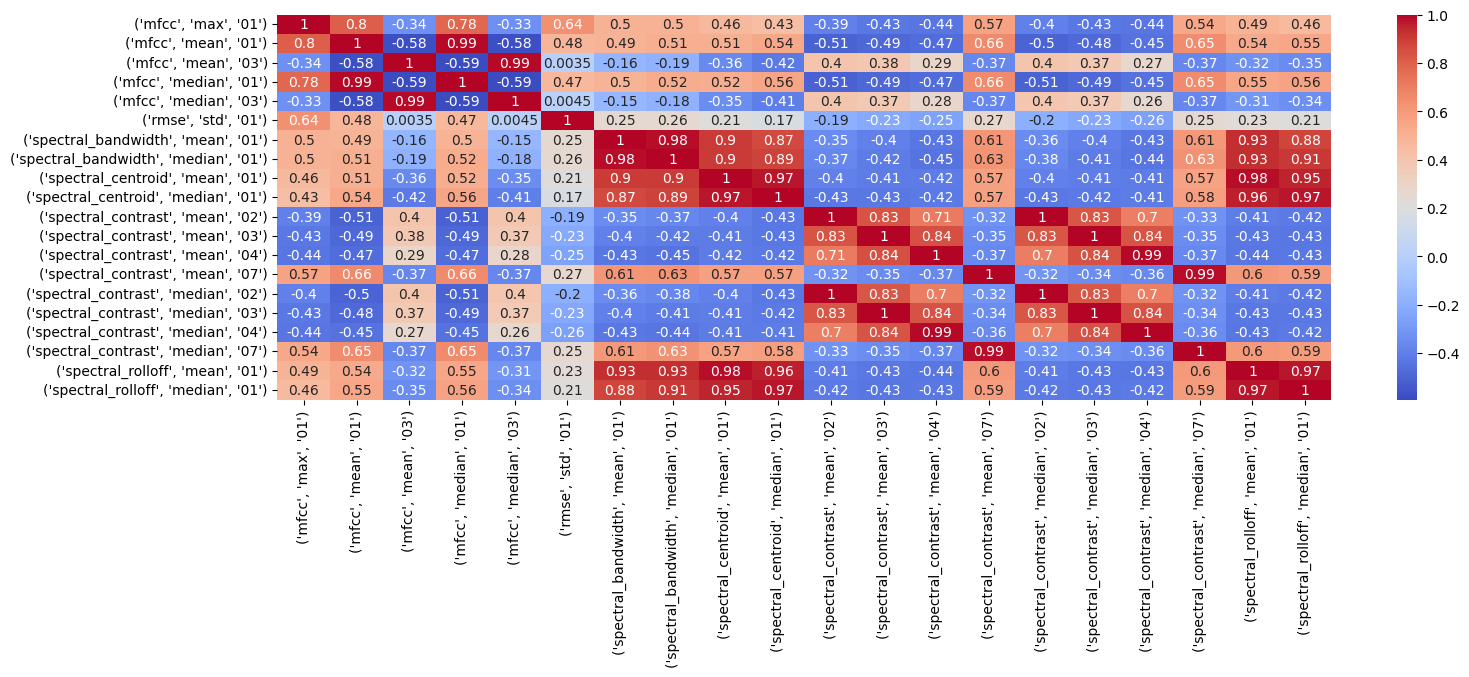

In [13]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


## Model selection

### SVM
SVM (Support Vector Machine), è un algoritmo basato su approccio supervisionato utilizzato per la classificazione e la regressione. Nella libreria sklearn, SVM fornisce diverse funzioni kernel per effettuare la trasformazione dei dati per consentire la classificazione  in un nuovo spazio di proiezione. Queste funzioni kernel sono specificate come parametri nell'implementazione SVM di sklearn.
I kernel più comunemente utilizzati sono:

1.  Sigmoid Kernel: Il kernel sigmoide trasforma i dati in uno spazio di dimensionalità superiore. L'idea è che proiettando i dati un uno spazio a dimensionalità superiore sia più semplice per un predittore effettuare il partizionamento e ottimizzare le prestazioni. La funzione kernel sigmoide è definita come:

    $$K(x, y) = tanh(gamma * <x, y> + coef0)$$

    dove <x, y> rappresenta il prodotto scalare tra i vettori x e y. Gamma e coef0 sono parametri che possono essere specificati quando si crea il modello SVM con il kernel sigmoide. La funzione sigmoide è simile alla funzione di attivazione sigmoide utilizzata nelle reti neurali ed è particolarmente utile per il supporto della classificazione binaria.

2. Radial Basis Function (RBF) Kernel: Il kernel RBF è uno dei più utilizzati. La funzione kernel RBF è definita come:

    $$K(x, y) = exp(-gamma * ||x - y||^2)$$

    dove ||x - y||^2 rappresenta la distanza euclidea al quadrato tra i vettori x e y. Gamma è un parametro che regola l'influenza dei singoli punti di addestramento nel calcolo del confine decisionale. Valori più grandi di gamma possono portare a un modello SVM più aderente ai dati di addestramento, potenzialmente causando overfitting.

3. Polynomial Kernel: Il kernel polinomiale trasforma i dati in uno spazio di dimensionalità superiore utilizzando una funzione polinomiale. La funzione kernel polinomiale è definita come:

    $$K(x, y) = (gamma * <x, y> + coef0)^degree$$

    dove <x, y> rappresenta il prodotto scalare tra i vettori x e y. Gamma, coef0 e degree sono parametri che possono essere specificati quando si crea il modello SVM con il kernel polinomiale. Degree controlla il grado del polinomio utilizzato per la trasformazione dei dati.

Nella ricerca del modello migliore gamma e coef0 verranno mantenuti i valori di default, si agirà invece sul modificare il kernel, il fattore C di regolarizzazione e sul grado nel caso di kernel polinomiale.

Il codice seguente addestra tre modelli utilizzando una diversa tipologia di kernel, mantenendo ovunque i valori di defaul. Dal grafico delle prestazioni(accuratezza) dei tre modelli addestrati, si può osservare  come i kernel "rbf","poly" hanno prestazioni paragonabili. Ha senso quindi procedere la model selection utilizzando in particolare questi due modelli.

<BarContainer object of 3 artists>

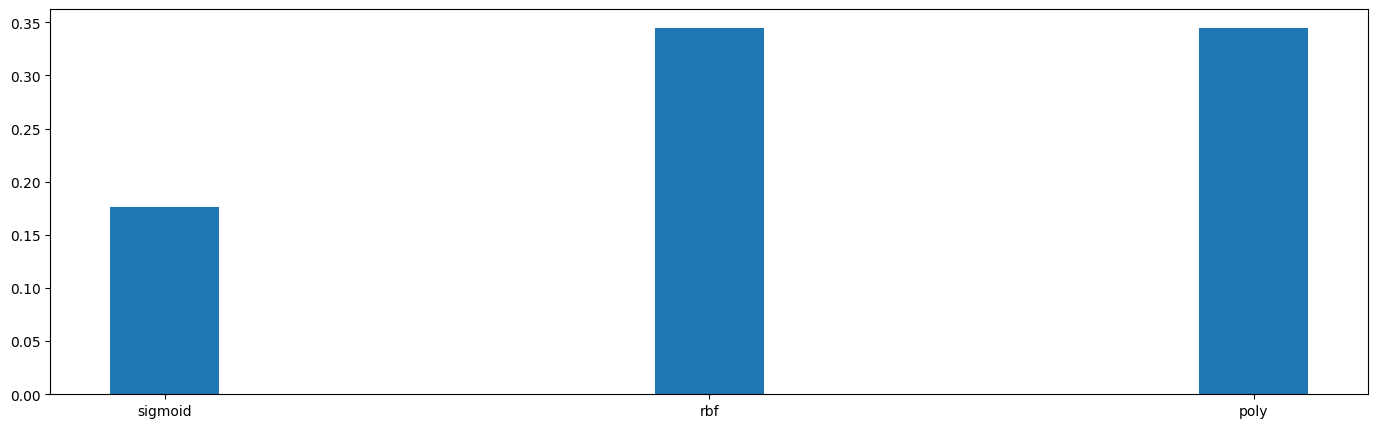

In [14]:

from sklearn.metrics import accuracy_score
# Calcolo dell'accuratezza

kernels =  [ "sigmoid","rbf","poly"]
score = []

for kernel in kernels:
    # Support vector classification.
    clf = skl.svm.SVC(probability=True, kernel = kernel)
    clf.fit(X_train, y_train)

    y_pred=clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    score.append(accuracy)

plt.bar(kernels,score,width=0.2)
 


Nel pezzo di codice seguente è fissato come kernel rbf e si procede a modificare il parametro C attraverso una ricerca "brute force" seppur limitata. Il grafico mostra come all'aumentare del valore di C aumenta anche il valore di accuratezza. Tuttavia l'accuratezza non cresce in modo lineare ma sembra convergere attorno al valore di 0.4 circa.

Text(0, 0.5, 'Accuracy')

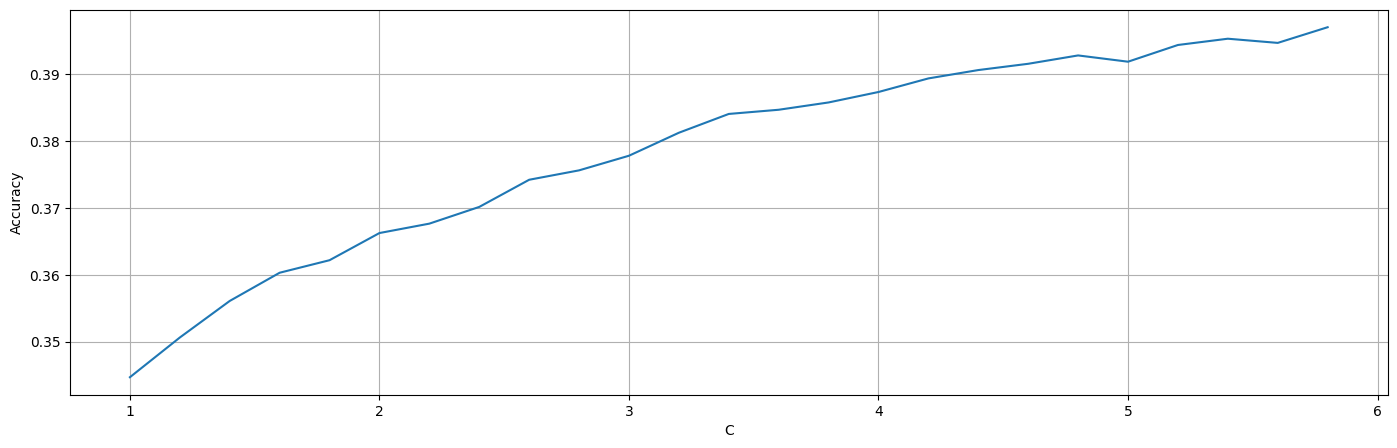

In [15]:
all_c = np.arange(1, 6, 0.2)
score=[]
best_cfl_c = 0
best_score_c =0

for c in all_c:
    # Support vector classification.
    clf = skl.svm.SVC(probability=True, kernel = 'rbf' , C=c)
    clf.fit(X_train, y_train)

    y_pred=clf.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    score.append(accuracy)
    
    if accuracy>best_score_c:
        best_cfl_c = c
        best_score_c = accuracy

plt.plot(all_c,score)
plt.grid()
plt.xlabel("C")
plt.ylabel("Accuracy")


Il secondo test è invece quello di fissare come kernel quello polinomiale e sperimentare diversi gradi. Il grafico seguente mostra come varia l'accuratezza al variare del grado del polinomio. Si puo osservare un picco al grado 7 e poi una discesa molto lenta.

Text(0, 0.5, 'Accuracy')

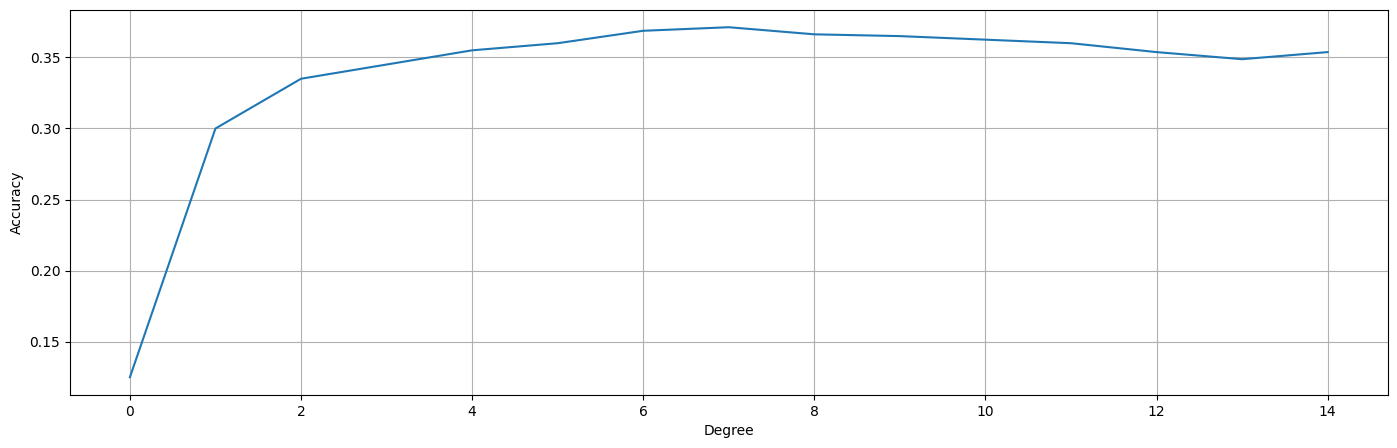

In [16]:
all_degree = range(15)
score=[]
best_cfl_d = 0
best_score_d =0

for d in all_degree:
    # Support vector classification.
    clf = skl.svm.SVC(probability=True, kernel = 'poly' , degree=d)
    clf.fit(X_train, y_train)

    y_pred=clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    score.append(accuracy)

    if accuracy>best_score_d:
        best_cfl_d = d
        best_score_d = accuracy

plt.plot(all_degree,score)
plt.grid()
plt.xlabel("Degree")
plt.ylabel("Accuracy")




Dopo aver addestrato i due modelli in parallelo si va a scegliere il miglior modello in assoluto. In questo modo verrà utilizzato questo classificatore per il confronto finale.

In [17]:
clf_best_SVM = None

if best_cfl_c<best_score_d:
    clf_best_SVM = skl.svm.SVC(probability=True, kernel = 'poly' , degree=best_cfl_d)
    clf_best_SVM.fit(X_train, y_train)
    print("miglior modello con kernel polinomiale: accuracy={}, grado={}".format(best_score_d,best_cfl_d))
else:
    clf_best_SVM = skl.svm.SVC(probability=True, kernel = 'rbf' , C=best_cfl_c)
    clf_best_SVM.fit(X_train, y_train)
    print("miglior modello con kernel rbf: accuracy={}, C={}".format(best_score_c,best_cfl_c))


miglior modello con kernel rbf: accuracy=0.39703125, C=5.799999999999999


Dopo aver trovato il modello migliore è possibile osservare gli errori commessi attraverso la visualizzazione della matrice di confusione. Per quanto il valore di accuratezza sia abbastanza basso, il classificatore non si comporta malissimo. Alcuni generi come il Folk , il Rock e Hip-Hop vengono ricinosciuti molto bene. Altri generi come invece il Pop o l'Instrumental, meno. Da qui si puo trovare una conferma dell'osservazione fatta dall'analisi dei dati : il classificatore fa fatica a riconoscere il genere Pop, e anzi lo confonde molto spesso per il genere Rock.

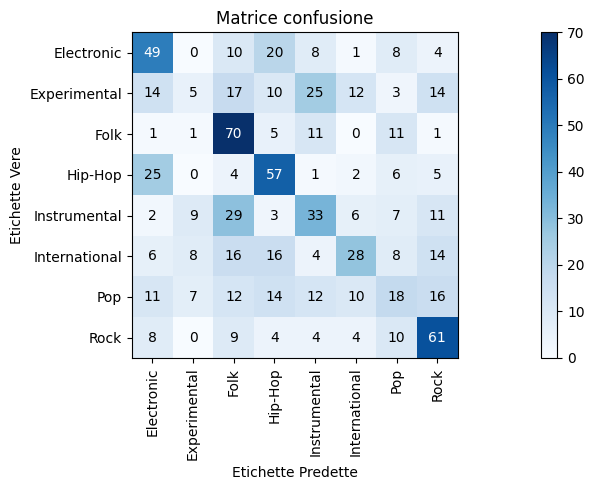

In [18]:
plot_matrix_confusion(clf_best_SVM,X_val,y_val,"Matrice confusione")

Dopo aver definito gli errori è possibile visualizzare le distribuzioni di ogni classe calcolata dal classificatore. Di seguito sono riportate due set di immagini a confronto, una con i punti del dataset di training e una senza. Due cose rilevanti è possibile osservare da questi grafici. La prima è che il Folk è classificato molto bene proprio perchè la distribuzione di probabilità è centrata quasi perfettamente nei punti. Appare strano invece come l'Hip pop che viene predetto molto bene abbia una distribuzione di probabilità non centrata nei punti.  Un osservazione interessante può essere fatta anche su Experimental. Si puo notare ,nella sua distribuzione, che ai punti nella parte alta del piano è assegnata una probabilità molto alta. Questo è dovuto al fatto che nel dataset di train gli unici punti che compaiano cosi in alto nel piano sono proprio quelli appartenenti a Experimental.

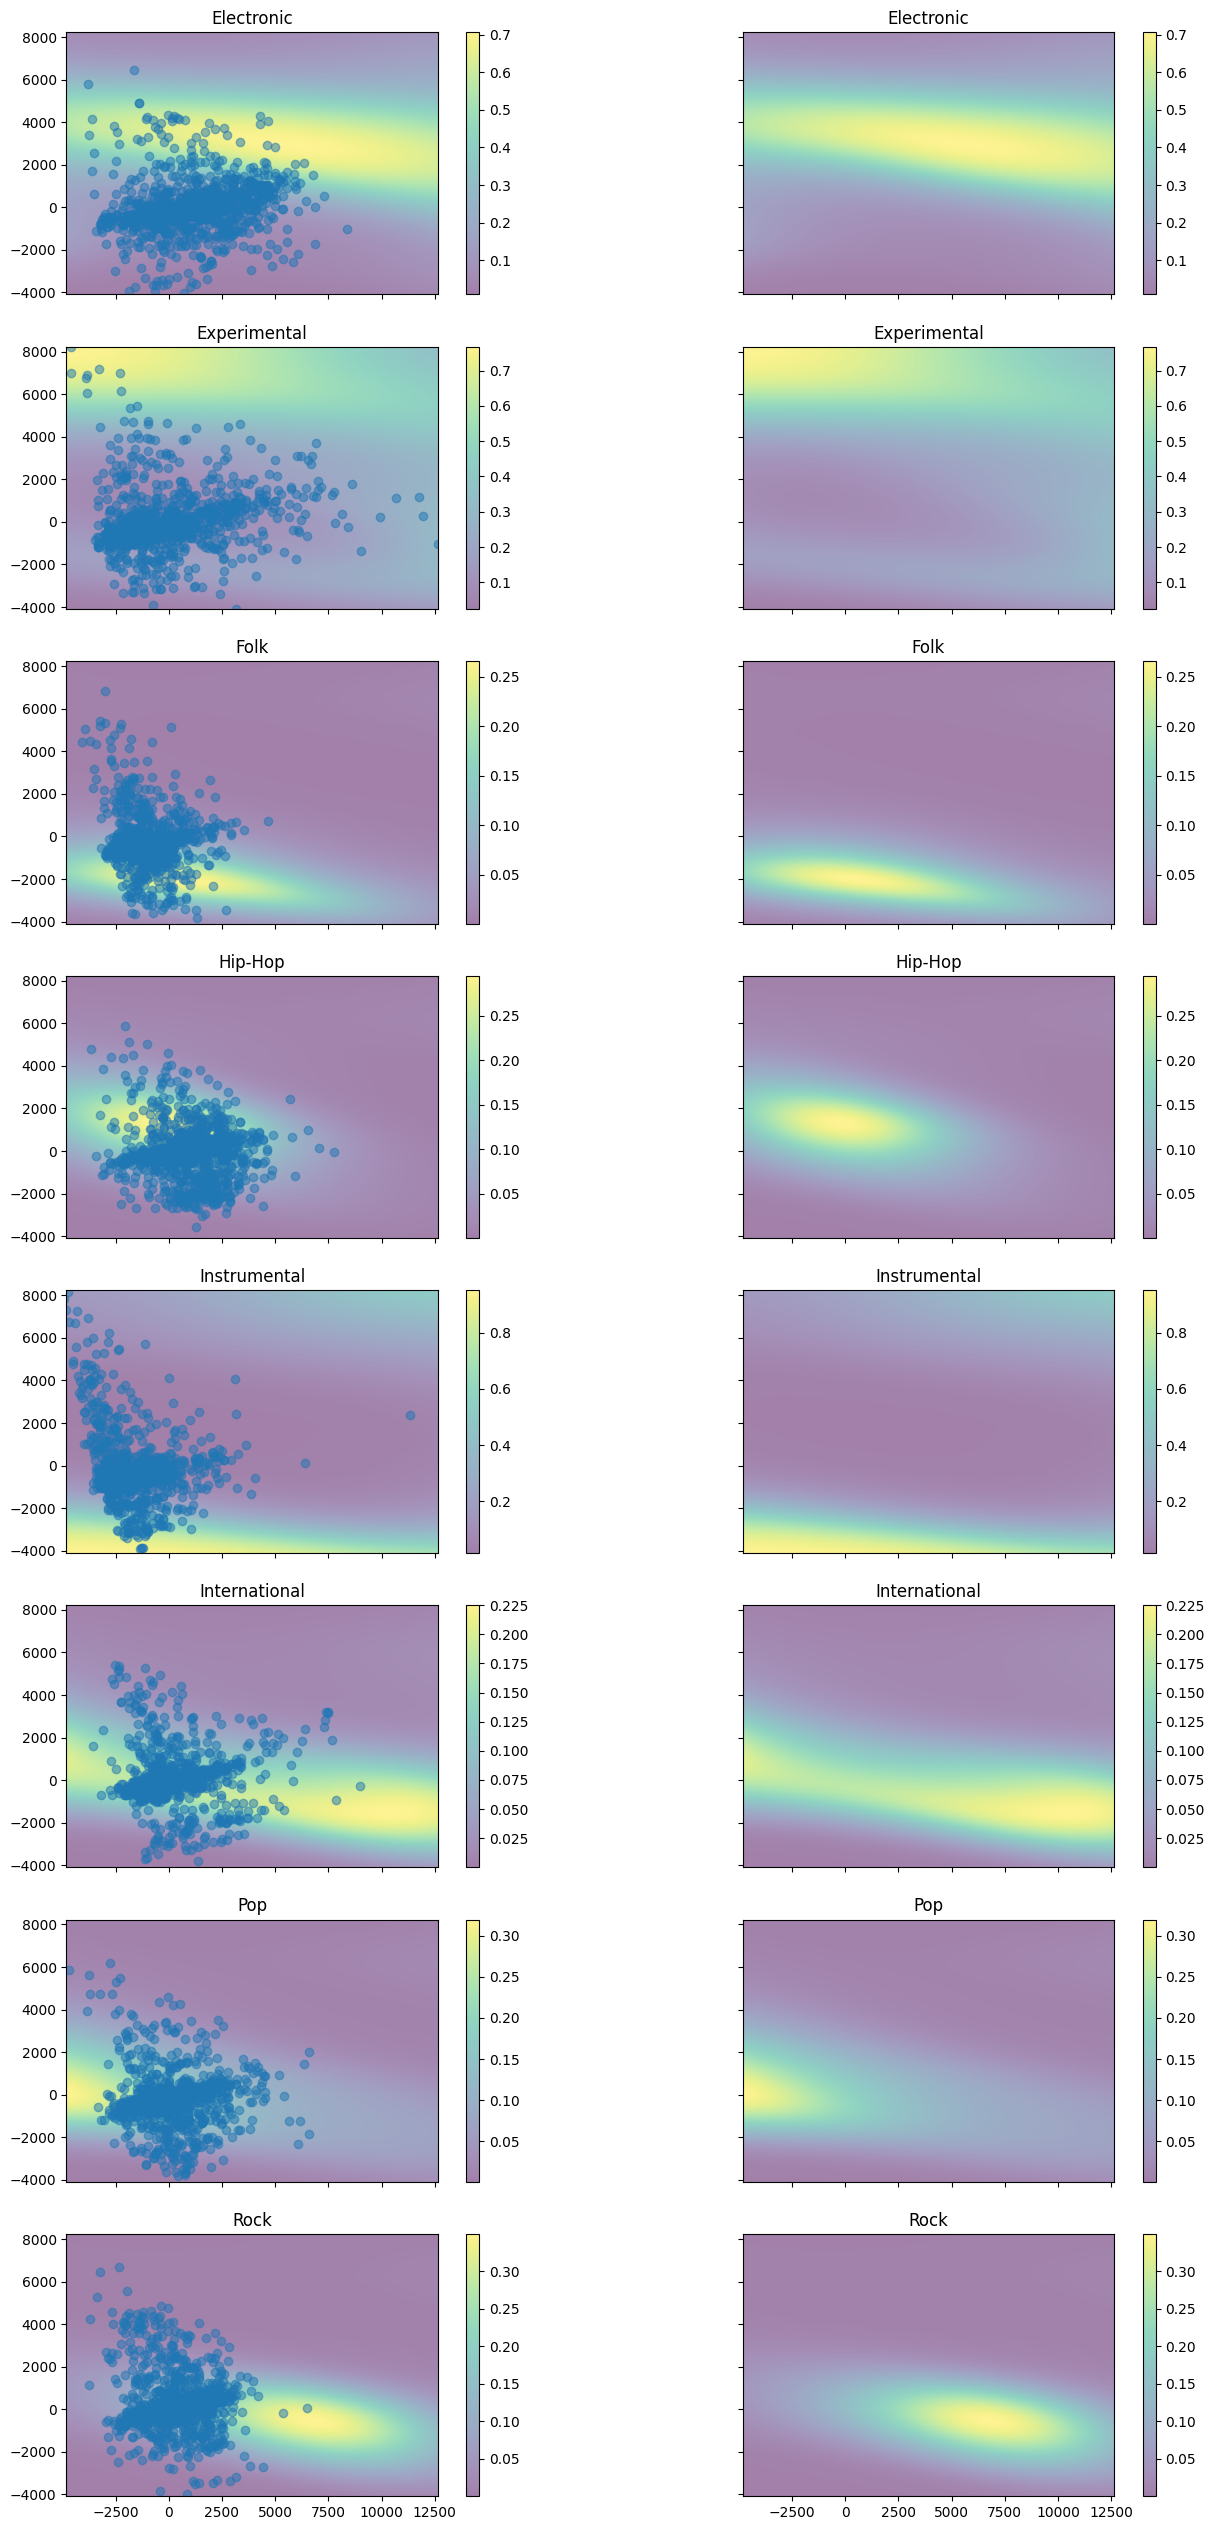

In [49]:
plot_ditribution(clf_best_SVM,X_train,tracks,features)

Infine viene effettuato un plot della curva di apprendimento. Il fatto che le prestazioni per il training set e il validation set convergono quasi a un punto comune indica l'assenza di overfitting.

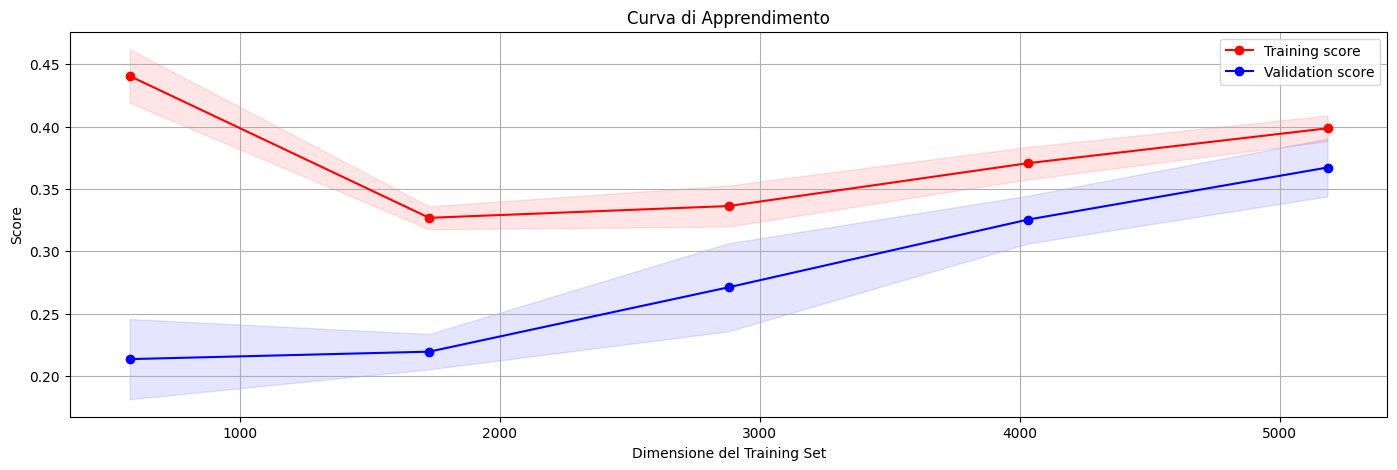

In [20]:
plot_learning_curve(clf_best_SVM,tracks,features)

### Gaussian naive bayes
I classificatori Gaussian Naive Bayes sono un tipo di algoritmo di classificazione probabilistica basato sul teorema di Bayes con l'assunzione di indipendenza condizionale gaussiana. Questi classificatori sono spesso utilizzati per problemi di classificazione quando le variabili di input sono continue e possono essere approssimate da una distribuzione gaussiana (distribuzione normale). In questo caso, data la distribuzione delle feature, ci si aspetta che possano avere delle prestazioni accettabili.
Il classificatore Gaussian Naive Bayes si basa sull'ipotesi di indipendenza condizionale, il che significa che assume che tutte le variabili di input siano indipendenti tra loro dato il valore dell'etichetta di classe. Questa assunzione semplifica il calcolo della probabilità condizionale e semplifica l'addestramento del classificatore.
La distribuzione a priori è un concetto fondamentale nella teoria bayesiana e viene utilizzata nel classificatore Gaussian Naive Bayes come parte del calcolo delle probabilità condizionali.
Nel contesto del classificatore Gaussian Naive Bayes, la distribuzione a priori si riferisce alla distribuzione di probabilità delle etichette di classe prima di osservare i dati di addestramento. Essa fornisce una conoscenza o un'ipotesi iniziale sulla probabilità di ciascuna classe prima di effettuare qualsiasi osservazione.

Le sperimentazioni su GNB riguardano la scelta di una distribuzione a priori differenti per vedere come variano le prestazioni. Si parte dalla distribuzione a priori di deafault che è una uniforme in cui tutte le classi hanno la stessa probabilità.

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np

clf = GaussianNB()

# Addestramento del classificatore
clf.fit(X_train, y_train)

# Predizione delle classi per i dati di test
y_pred = clf.predict(X_val)

# Calcolo della matrice di confusione
cm_init = confusion_matrix(y_val, y_pred)


Dopo aver addestrato il modello iniziale con i parametri di default si procede a creare diverse distribuzioni di probabilità a priori. Nel codice seguente le distribuzioni vengono calcolate a partire dalle informazioni estratte dalla matrice di confusione del modello appena addestrato. Si precisa che questo approccio è un modo come un altro per generare nuove distribuzioni. Essendo distribuzioni a priori i valori di probabilità  **non** devono dipendere dai dati. 

In particolare vengono generate 5 nuove distribuzioni costruite considerando e normalizzando:
1.  i valori sulla diagonale della matrice di confusione del modello addestrato con i parametri di default
2.  i massimi per ogni riga della matrice di confusione del modello addestrato con i parametri di default
3.  i minimi per ogni riga della matrice di confusione del modello addestrato con i parametri di default
4.  la media per ogni riga della matrice di confusione del modello addestrato con i parametri di default
5.  valori randomici

In [22]:

import random

all_distr = []
all_distr_name = []

#Distribuzione uniforme
priori_base= [1/len(clf.classes_) for i in range (len(clf.classes_))]
all_distr.append(priori_base)
all_distr_name.append("Uniforme")

#Distribuzione cotruita considerando e normalizzando i valori sulla diagonale della matrice "cm_init"
distr = [cm_init[i][i] for i in range(len(clf.classes_))]
sum_tot= sum(distr)
distr_diag = [num / sum_tot for num in distr]
all_distr.append(distr_diag)
all_distr_name.append("Diagonale")

#Distribuzione cotruita considerando e normalizzando i massimi per ogni riga della matrice "cm_init"
distr = [cm_init[i].max() for i in range(len(clf.classes_))]
sum_tot= sum(distr)
distr_max = [num / sum_tot for num in distr]
all_distr.append(distr_max)
all_distr_name.append("Max")

#Distribuzione cotruita considerando e normalizzando i minimi per ogni riga della matrice "cm_init"
distr = [cm_init[i].min() for i in range(len(clf.classes_))]
sum_tot= sum(distr)
distr_min = [num / sum_tot for num in distr]
all_distr.append(distr_min)
all_distr_name.append("Min")

#Distribuzione cotruita considerando e normalizzando la media per ogni riga della matrice "cm_init"
distr = [cm_init[i].mean() for i in range(len(clf.classes_))]
sum_tot= sum(distr)
distr_mean = [num / sum_tot for num in distr]
all_distr.append(distr_mean)
all_distr_name.append("Mean")

#Distribuzione cotruita considerando e normalizzando valori random
distr = [random.random() for _ in range(len(clf.classes_))]
sum_tot= sum(distr)
distr_random = [num / sum_tot for num in distr]
all_distr.append(distr_random)
all_distr_name.append("Random")


Il passo successivo una volta create le distribuzioni a priori è addestrare più modelli e confrontare i risutati. Un primo confronto può essere fatto tramite le matrici di confusione, una per ogni nuovo modello. Quello che si può notare è che la scelta della distribuzione a priori influenza leggermente il risultato della classificazione. Ad esempio il pop ,che è classificato quasi sempre male, utilizzando una distribuzione a priori "MIN" viene riconosciuto decisamente meglio. Ciò è dovuto al fatto che con la distribuzione a priori "MIN" Rock ha come probabilità a priori 0. Quindi tutti i modelli di classificazione non confondono più i punti di rock con pop.

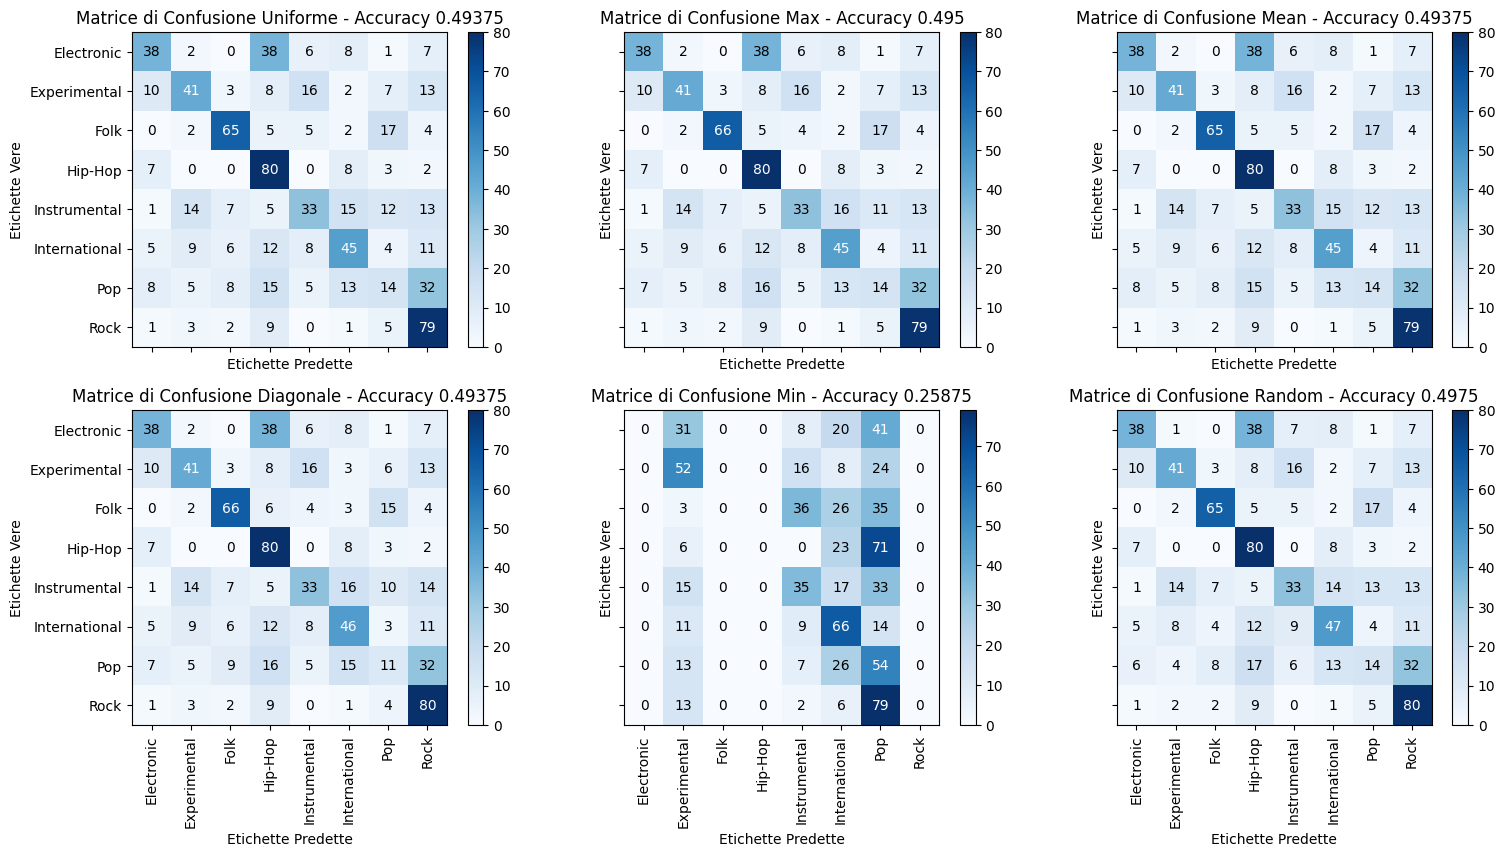

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np

f, axarr = plt.subplots(2,3,figsize=(18, 9),sharex=True, sharey=True)
all_pos_to_plot = [[0,0],[1,0],[0,1],[1,1],[0,2],[1,2]]
dist_best = []
best_acc = 0

for distr_index in range(len(all_distr)):
    # Creazione del classificatore Gaussian Naive Bayes con distribuzione a priori
    clf = GaussianNB(priors=all_distr[distr_index])

    # Addestramento del classificatore
    clf.fit(X_train, y_train)
  
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    if accuracy > best_acc:
        best_acc = accuracy
        dist_best = all_distr[distr_index]

    # Calcolo della matrice di confusione
    cm = confusion_matrix(y_val, y_pred)

    # Definizione delle etichette delle classi
    class_labels = np.unique(np.concatenate((y_val, y_pred)))
    tick_marks = np.arange(len(class_labels))

    pos_to_plot = all_pos_to_plot[distr_index]

    # Plot della matrice di confusione
    mappable = axarr[pos_to_plot[0]][pos_to_plot[1]].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axarr[pos_to_plot[0]][pos_to_plot[1]].set_title('Matrice di Confusione {} - Accuracy {}'.format(all_distr_name[distr_index],accuracy))
    axarr[pos_to_plot[0]][pos_to_plot[1]].set_xticks(tick_marks, class_labels,rotation=90)
    axarr[pos_to_plot[0]][pos_to_plot[1]].set_yticks(tick_marks, class_labels)
    f.colorbar(mappable)

    # Aggiunta dei valori all'interno della matrice di confusione
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        axarr[pos_to_plot[0]][pos_to_plot[1]].text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

    axarr[pos_to_plot[0]][pos_to_plot[1]].set_xlabel('Etichette Predette')
    axarr[pos_to_plot[0]][pos_to_plot[1]].set_ylabel('Etichette Vere')


Per capire come mai le predizioni cambiano al variare delle distribuzioni a priori è possibile graficare la distribuzione di un genere specifico(in questo caso pop) al variare del modello di classidicazione. Nell'immagine sottostante si può vedere come per quasi tutti i modelli  c'è solo una piccola regione in cui il classificatore è sicuro di trovare elementi della classe pop. Questa regione ha ovviamente caratteristiche diverse in base al modello. Tuttavia se si osserva il grafico con la distribuzione a priori "MIN" si puo vedere come ci sia una regione molto più ampia in cui il classificatore è sicuro di trovare entry di quella classe. Questa caratteristica porta ad aumentare il numero pop classificati correttamente.

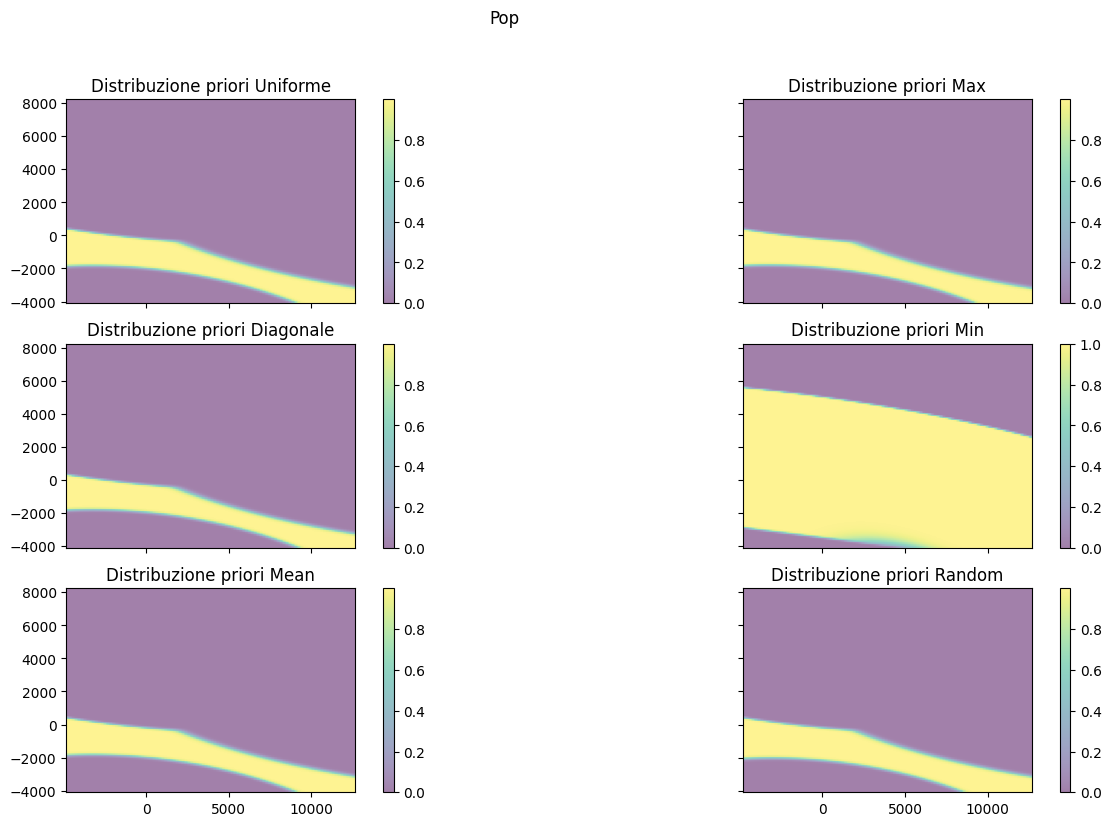

In [24]:
all_pos_to_plot = [[0,0],[1,0],[0,1],[1,1],[2,0],[2,1]]
genre = "Pop"
genre_id = 6

f, axarr = plt.subplots(3,2,figsize=(16, 9),sharex=True, sharey=True)
plt.suptitle(genre)

#Converto i dati del dataset in due dimensioni
pc = skl.decomposition.PCA(n_components=2)
value = pc.fit_transform(X_train)

for distr_index in range(len(all_distr)):

    # Creazione del classificatore Gaussian Naive Bayes con distribuzione a priori
    clf = GaussianNB(priors=all_distr[distr_index])

    # Addestramento del classificatore
    clf.fit(X_train, y_train)

    small = tracks['set', 'subset'] <= 'small'
    genre1 = tracks['track', 'genre_top'] == genre

    #Filtro i dati per genere e li proietto in un piano bidimensionale
    X = features.loc[small & (genre1)]
    X.columns = X.columns.to_flat_index()
    X.columns = [str(elem) for elem in X.columns]
    X=pc.transform(X)

    u = np.linspace(value[:,0].min(), value[:,0].max(), 100)
    v = np.linspace(value[:,1].min(), value[:,1].max(), 100)
    z = np.zeros((len(u), len(v)))
    y0 = np.zeros((len(u), len(v)))

    for i in range(len(u)):
        for j in range(len(v)):
            data = []
            temp = []

            #Creo una coppia di punti nello spazio bidimensionale
            temp.append(u[i])
            temp.append(v[j])
            data.append(temp.copy())

            #converto la coppia di punti nello spazio 140-dimensionale
            to_pred= pc.inverse_transform(data)

            #predico la distribuzione di probabilità del punto nello spazio a 140 features
            pr = clf.predict_proba(to_pred)
            y0[i,j] = pr[0][genre_id]


    u, v = np.meshgrid(u, v)
    pos_to_plot = all_pos_to_plot[distr_index]


    mappable = axarr[pos_to_plot[0]][pos_to_plot[1]].imshow(y0, origin='lower', extent=(value[:,0].min(), value[:,0].max(), value[:,1].min(), value[:,1].max()), alpha=.5)
    axarr[pos_to_plot[0]][pos_to_plot[1]].set_title('Distribuzione priori {}'.format(all_distr_name[distr_index]))
    f.colorbar(mappable)


Infine è rappresentato anche in questo caso la curva di apprendimento.

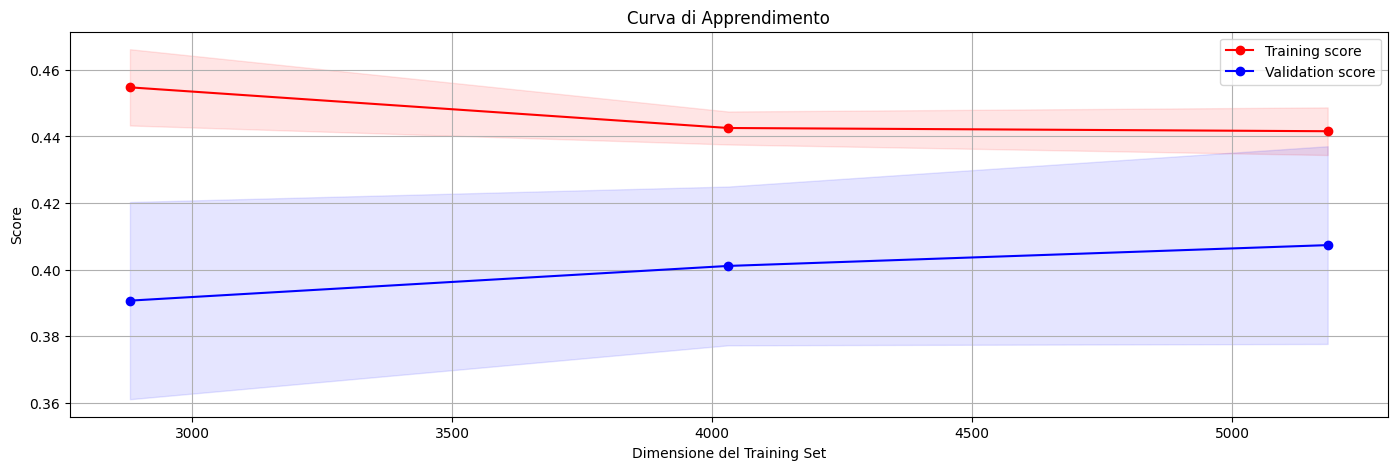

In [25]:
clf_best_GB = GaussianNB(priors=dist_best)
clf_best_GB.fit(X_train, y_train)
plot_learning_curve(clf_best_GB,tracks,features)

### Random forest

Un classificatore Random Forest è un algoritmo di machine learning che si basa sull'idea di combinare diversi alberi decisionali per la classificazione. È una tecnica di apprendimento ensemble, in cui più modelli (alberi decisionali) vengono addestrati e i loro risultati vengono combinati per ottenere una previsione finale.

Per questo modello di classificazione la model selection si basa sulla scelta di 4 parametri : criterion, profondità massima di un albero decisionale, numero di stimatori e il numero massimo di features da considerare. La ricerca è "brute force" limitata, nel senso che si provano un sottoinsieme di combinazione di questi parametri e si va a scegliere il modello che massimizza l'accuratezza. 

In scikit-learn (sklearn), il parametro "criterion" indica la funzione utilizzata per misurare la qualità di una suddivisione durante la creazione degli alberi decisionali.

Il parametro "criterion" può essere impostato su tre valori principali:

1. **gini**:
    Se si imposta criterion="gini", viene utilizzato l'indice di Gini come criterio per la suddivisione dei nodi durante la costruzione degli alberi decisionali. L'indice di Gini misura la purezza delle divisioni, valutando la probabilità che un elemento selezionato casualmente venga classificato erroneamente dopo essere stato assegnato a un sottoinsieme. Minimizzare l'indice di Gini corrisponde a massimizzare la purezza delle divisioni.

2. **entropy**:
    Se si imposta criterion="entropy", viene utilizzata l'entropia come criterio per la suddivisione dei nodi. L'entropia misura il disordine o l'incertezza all'interno di un insieme di dati. Minimizzando l'entropia, si cerca di massimizzare l'informazione guadagnata attraverso la suddivisione dei nodi.

3. **log loss entropy**: 
    simile a entropy, ma utilizza una formula leggermente diversa.


L'immagine seguente mostra alcuni risultati della ricerca brute force e mostra come sono evolute le prestazioni al variare del criterion. Si puo notare come il criterion non influenzi eccessivamente l'accuratezza del modello finale, sia giny che entropy che loss, raggiungono prestazioni che sono tra loro paragonabili.

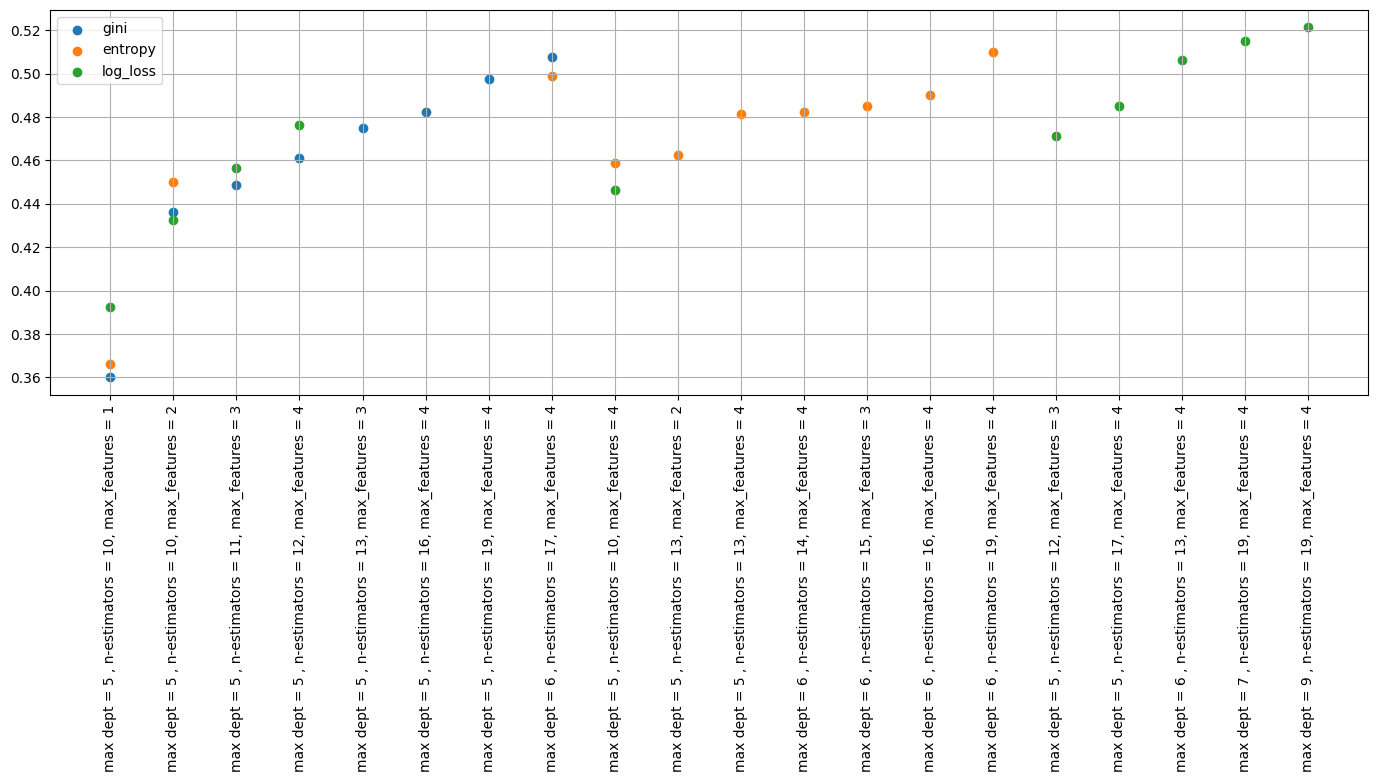

In [26]:
from sklearn.ensemble import RandomForestClassifier

to_plot = []
label_to_plot = []
all_criteria = ['gini', 'entropy', 'log_loss']

best_acc=0
best_max_depth=0
best_n_estimators=0
best_max_features=0
best_criterion=""

for criteria in all_criteria:
    to_plot = []
    label_to_plot = []
    best_acc=0
    for i in range(5,15):
        for j in range(10,20):
            for k in range(1,5):
                clf = RandomForestClassifier(max_depth=i, n_estimators=j, max_features=k,criterion=criteria)

                # Addestramento del classificatore
                clf.fit(X_train, y_train)

                y_pred = clf.predict(X_val)
                accuracy = accuracy_score(y_val, y_pred)
                
                if accuracy > best_acc:
                    best_acc= accuracy
                    best_max_depth=i
                    best_n_estimators=j
                    best_max_features=k
                    best_criterion=criteria
                    to_plot.append(accuracy)
                    label_to_plot.append("max dept = {} , n-estimators = {}, max_features = {}".format(i,j,k))

    plt.scatter(label_to_plot,to_plot, label=criteria)
    plt.xticks(rotation=90)
    plt.grid()
    plt.legend()

Una volta trovato il modello migliore è possibile graficare la sua matrice di confusione. Cosi come i modelli precedenti anche Random forest tende a classificare molto bene Folk, Hip hop e Rock. Allo stesso modo Pop e Instrumental vengono classificati molto male. Addirittura solo 9 entry di pop sono classificate correttamente, tutte le altre sono errori. Il pop è confuso notevolmente con il Rock ma anche abbastanza con l'experimental.

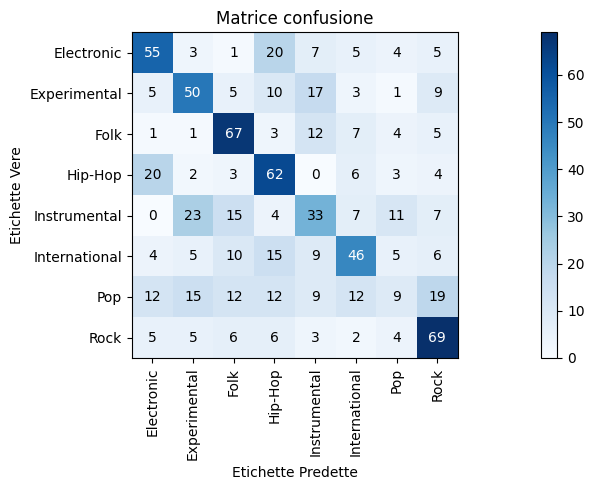

In [27]:
clf_best_RF = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators, max_features=best_max_features,criterion=best_criterion)
clf_best_RF.fit(X_train, y_train)
plot_matrix_confusion(clf_best_RF,X_val,y_val,"Matrice confusione")

Il codice seguente mette a confronto le distribuzioni di probabilità delle varie classi individuate dal classificatore.  Osservando l'immagine del pop si nota una stranezza. La distribuzione di probabilità sembra indovinare abbastanza bene la posizione dei punti, nonostante ciò fa comunque molta fatica a classificare correttamente i punti di questa classe. Una possibile interpretazione del problema è che i punti di Pop si sovrappongono con quelli di Rock, e la distribuzione di probabilità di rock è piu "forte". Questo magari induce a classificare i punti in quella specifica regione più a favore del rock, come dimostra il fatto che molto spesso Pop e Rock sono confusi tra loro.

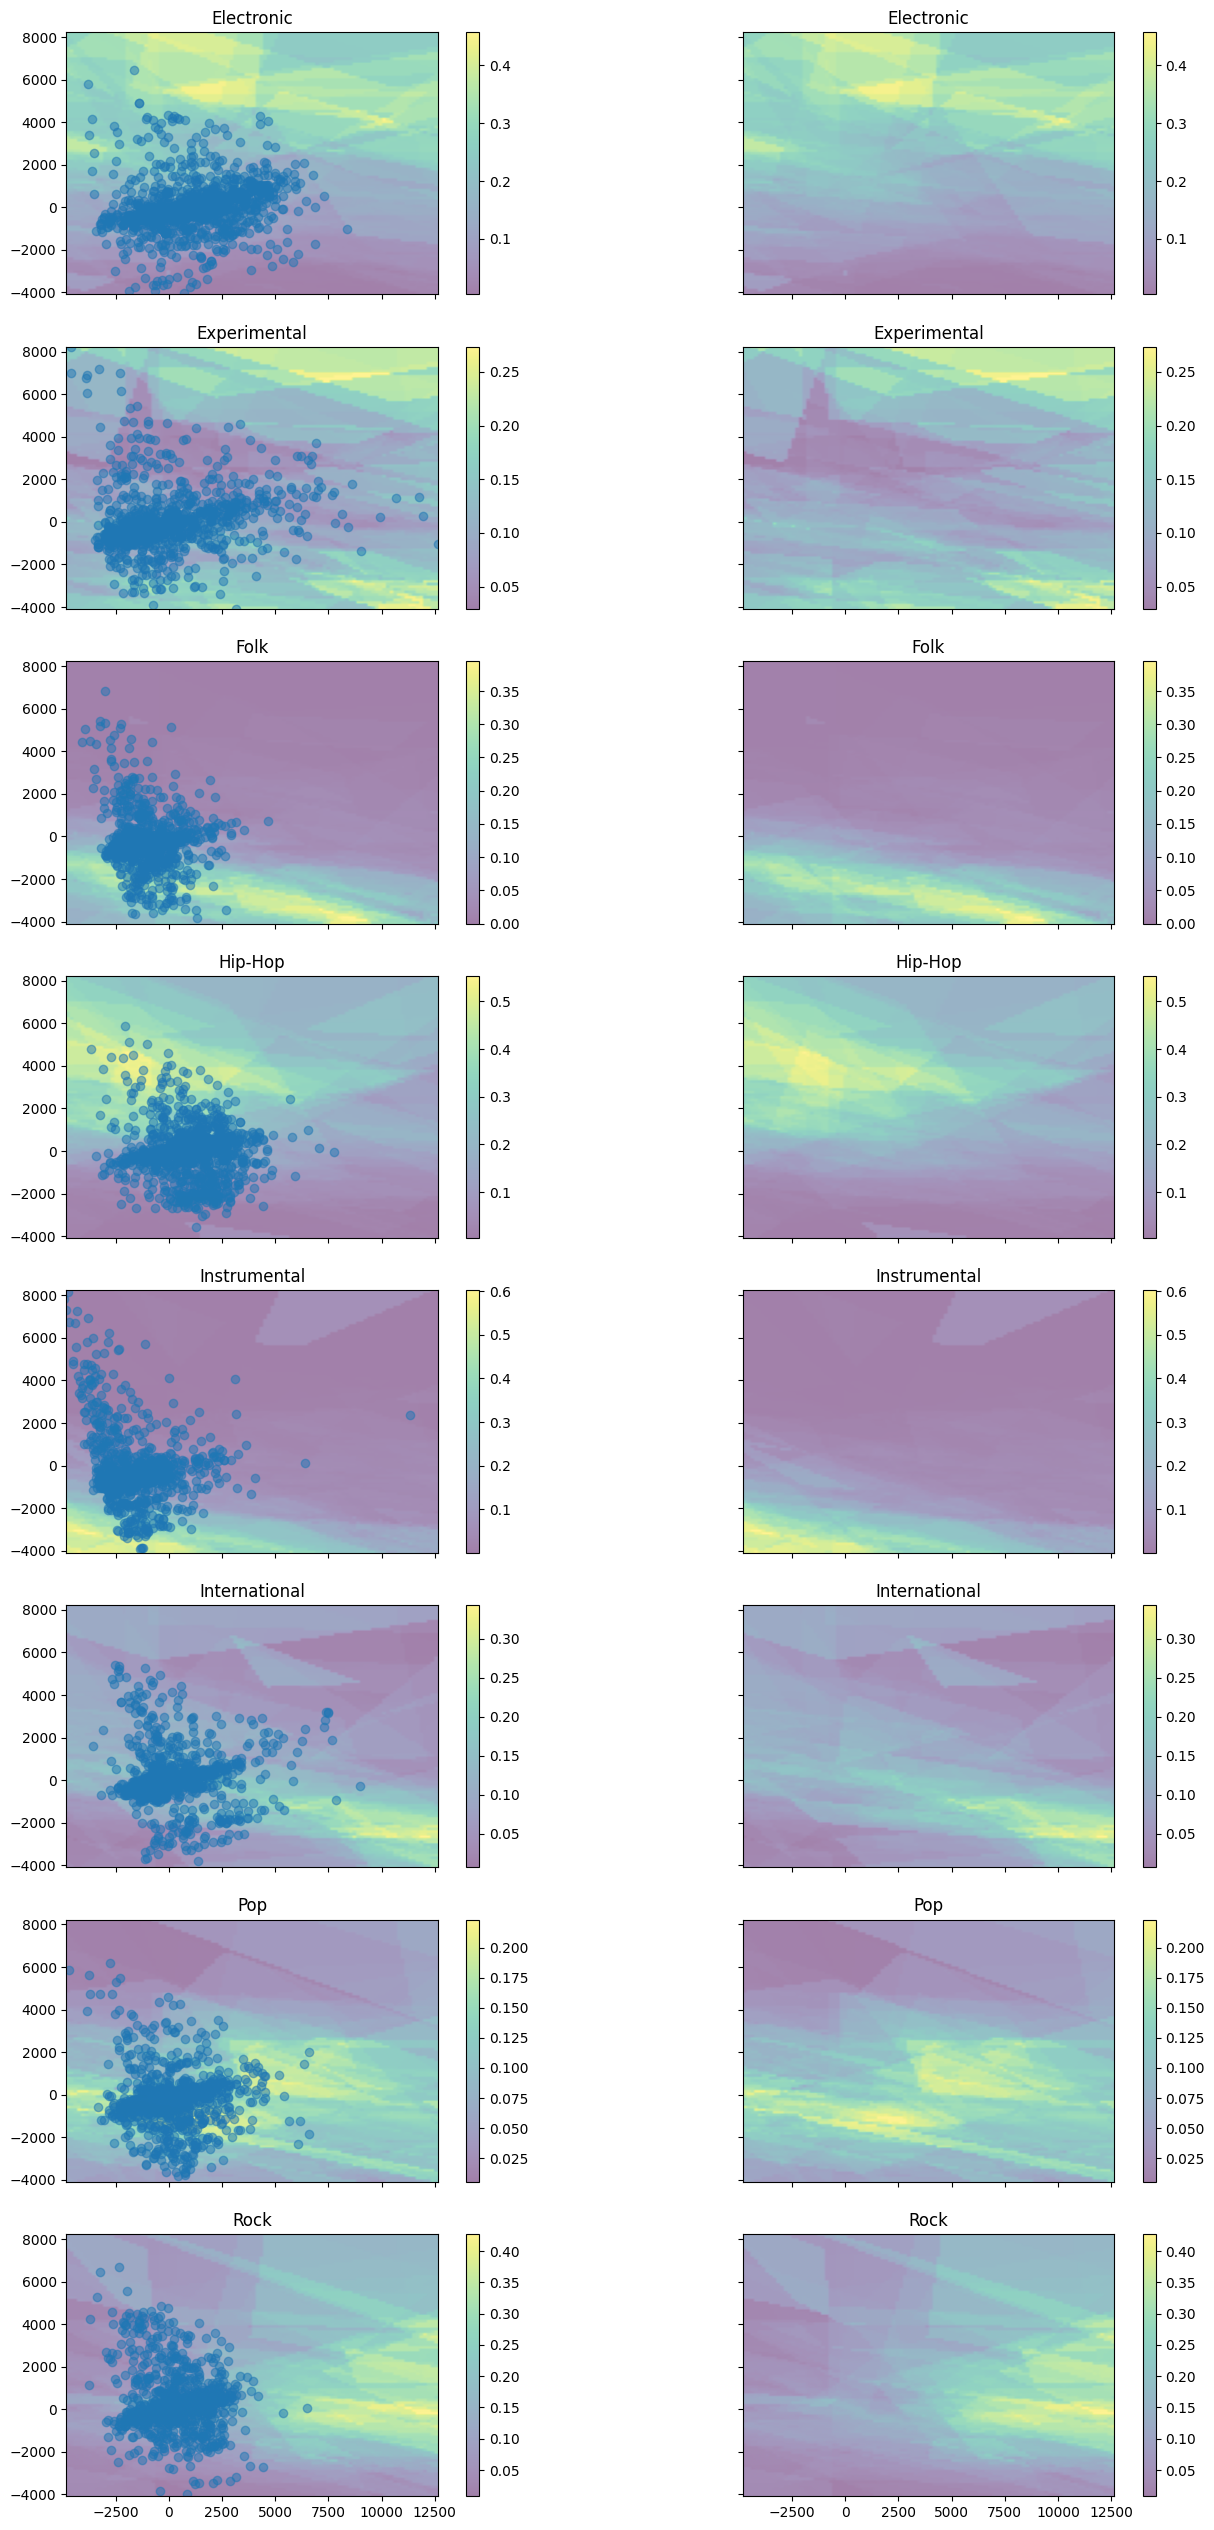

In [48]:
plot_ditribution(clf_best_RF,X_train,tracks,features)

Si plotta per concludere anche la curva di apprendimento. Un risultato strano che si ottiene è che per il training set si ottiene inizialmente un accuratezza molto alta, che poi tende a diminuire all'aumentare delle dimensioni del dataset considerato.

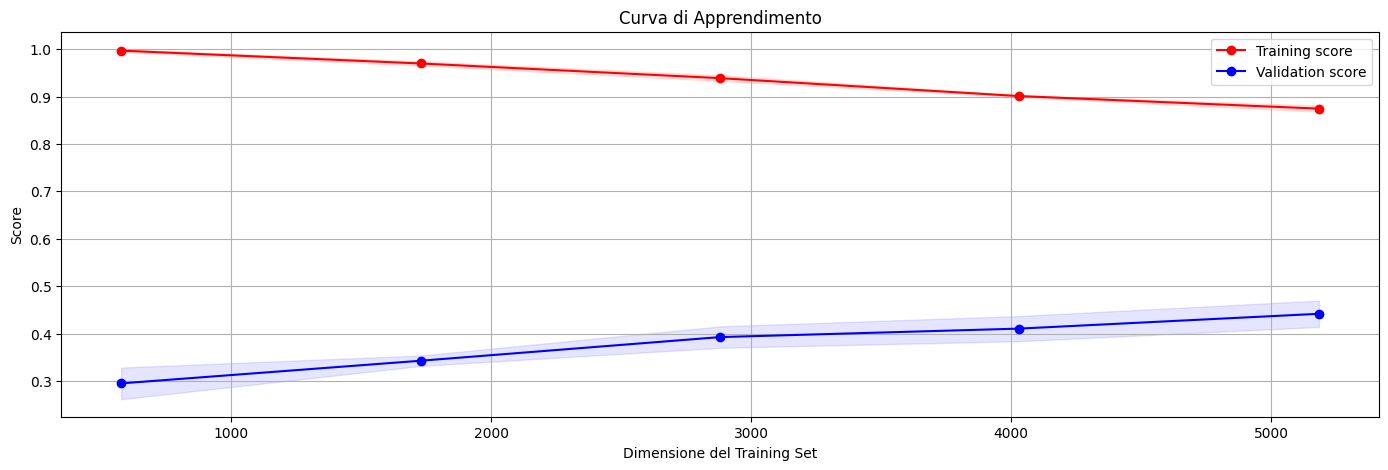

In [29]:
plot_learning_curve(clf_best_RF,tracks,features)

## Confronto classificatori
Individuati i classificatori migliori attraverso un operazione di model selection, è possibile mettere a confronto i vari modelli utilizzando questa volta i dati di test. Infatti la fase di ricerca del modello migliore è stata realizzata utilizzando dati di validazione. Il primo confronto che è possibile effettuare è quello che riguarda la matrice di confusione e l'accuratezza. Si nota immediatamente che il modello peggiore è SVM ma anche che i tre modelli sono molto simili tra loro. I modelli infatti riescono a riconoscere correttamente le stesse classi, e allo stesso tempo fanno fatica ad individuare sempre i soliti generi. Si noti però come SVM riconosca decisamente meglio Hip-Pop e Folk , mentre fatica a riconoscere Rock e Instrumental che sono riconosciuti meglio dagli altri classificatori.

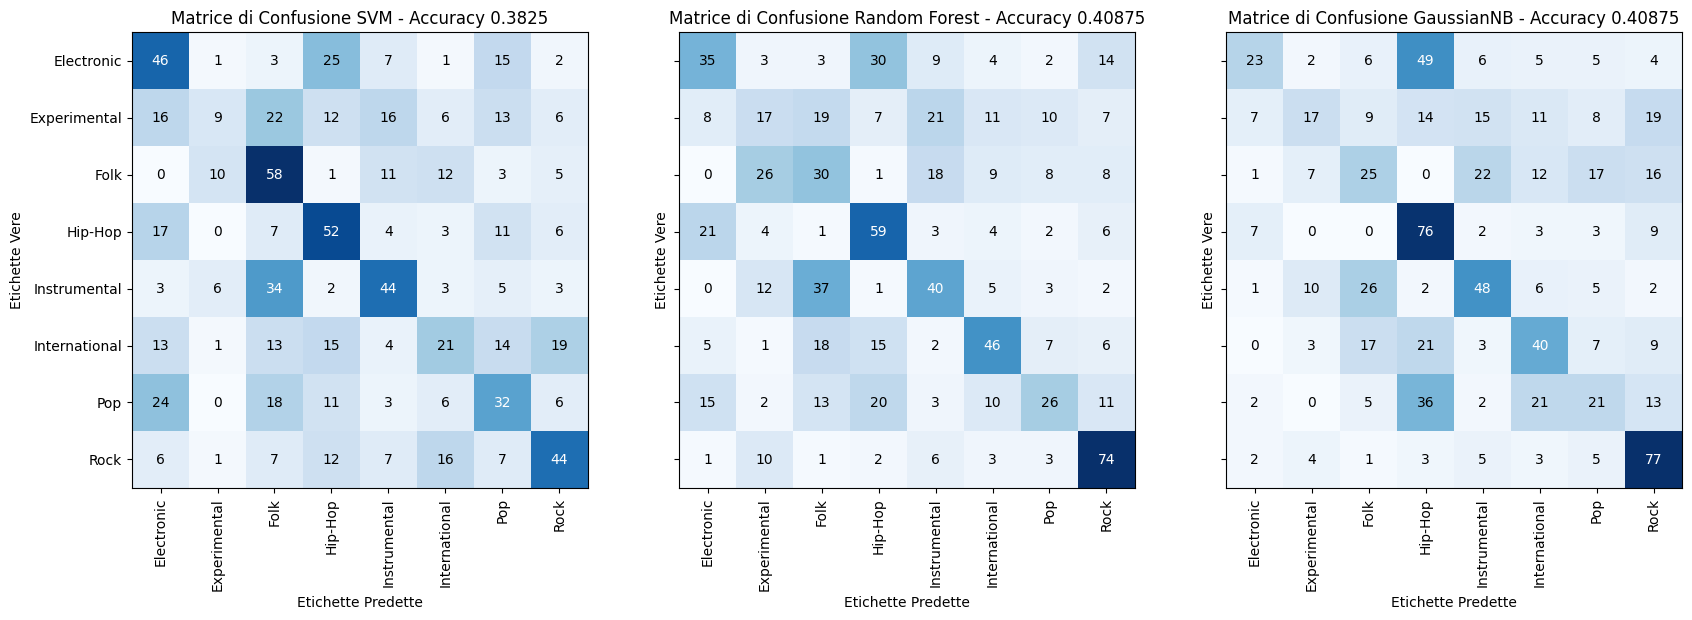

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np

f, axarr = plt.subplots(1,3,figsize=(20, 30),sharex=True, sharey=True)

all_classifier = []
all_classifier.append(clf_best_SVM)
all_classifier.append(clf_best_RF)
all_classifier.append(clf_best_GB)

all_classifier_name = ["SVM","Random Forest","GaussianNB"]

for index_clf in range(len(all_classifier)):

    y_pred = all_classifier[index_clf].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Calcolo della matrice di confusione
    cm = confusion_matrix(y_test, y_pred)

    # Definizione delle etichette delle classi
    class_labels = np.unique(np.concatenate((y_test, y_pred)))
    tick_marks = np.arange(len(class_labels))

    pos_to_plot = all_pos_to_plot[index_clf]

    # Plot della matrice di confusione
    axarr[index_clf].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axarr[index_clf].set_title('Matrice di Confusione {} - Accuracy {}'.format(all_classifier_name[index_clf],accuracy))
    axarr[index_clf].set_xticks(tick_marks, class_labels,rotation=90)
    axarr[index_clf].set_yticks(tick_marks, class_labels)

    # Aggiunta dei valori all'interno della matrice di confusione
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        axarr[index_clf].text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

    axarr[index_clf].set_xlabel('Etichette Predette')
    axarr[index_clf].set_ylabel('Etichette Vere')

Un secondo confronto che è possibile effettuare è quello sulla distrubuzione di probabilità delle classi. In particolare si vuole vedere quale è la distribuzione di probabilità del genere che è classifiata meglio di tutte, ovvero il Rock. Quello che si può notare è che grossomodo i classificatori hanno individuato una regione di spazio comune in cui sono più certi ci saranno entry appartenenti alla classe Rock. Per quanto la ragione sia comune, le distrubuzioni sono leggermente diverse tra loro. SVM raggiunge il massimo della probabilità in quella regione 0.3, e la distrubuzione tende a diventare più rarefatta man mano che ci si allontana dal centro. Con Random forest la distrubuzione è come se fosse formata da più "pennellate" dovute al fatto probabilmente che ci sono più classificatori che interagiscono tra loro. Infine con Gaussian NB c'è un regione delimitata in maniera chiara in cui il classificatore è certo al 100% (probabilità 1) che li si trovino entry della classe rock. Probabilmente questa maggiore convinzione determina il fatto che Gaussian NB abbia le prestazioni migliori degli altri.

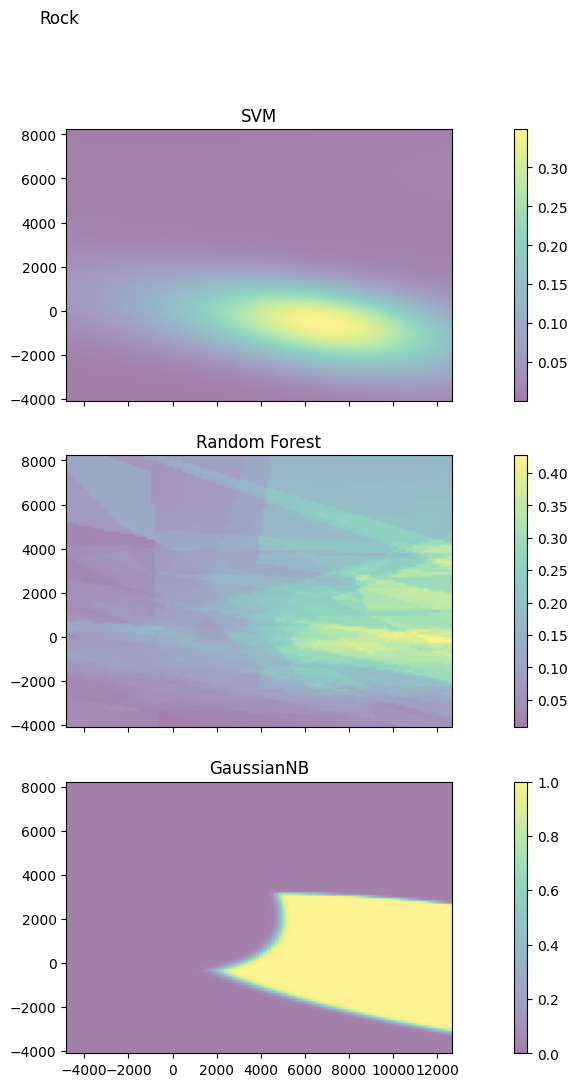

In [31]:
f, axarr = plt.subplots(3,1,figsize=(16, 12),sharex=True, sharey=True)
class_name='Rock'
class_id=7

plt.suptitle(class_name)

for index_clf in range(len(all_classifier)):
    plot_ditribution_single_class(all_classifier[index_clf],X_train,tracks,features, axarr[index_clf],f,class_name,class_id,all_classifier_name[index_clf])



Si conclude il confronto analizzando la curva di calibrazione. In questo caso specifico viene mostrata la curva di calibrazione della classe Electronic. I punti dovrebbero essere posti lungo la bisettrice del primo e terzo quadrante. Più si discostano da questo andamento è peggio si comporta il classifciatori. SVM si conferma il classificatore migliore da questo punto di vista , seguito da Random Forset. Gaussian NB invece mostra un andamento peggiore.

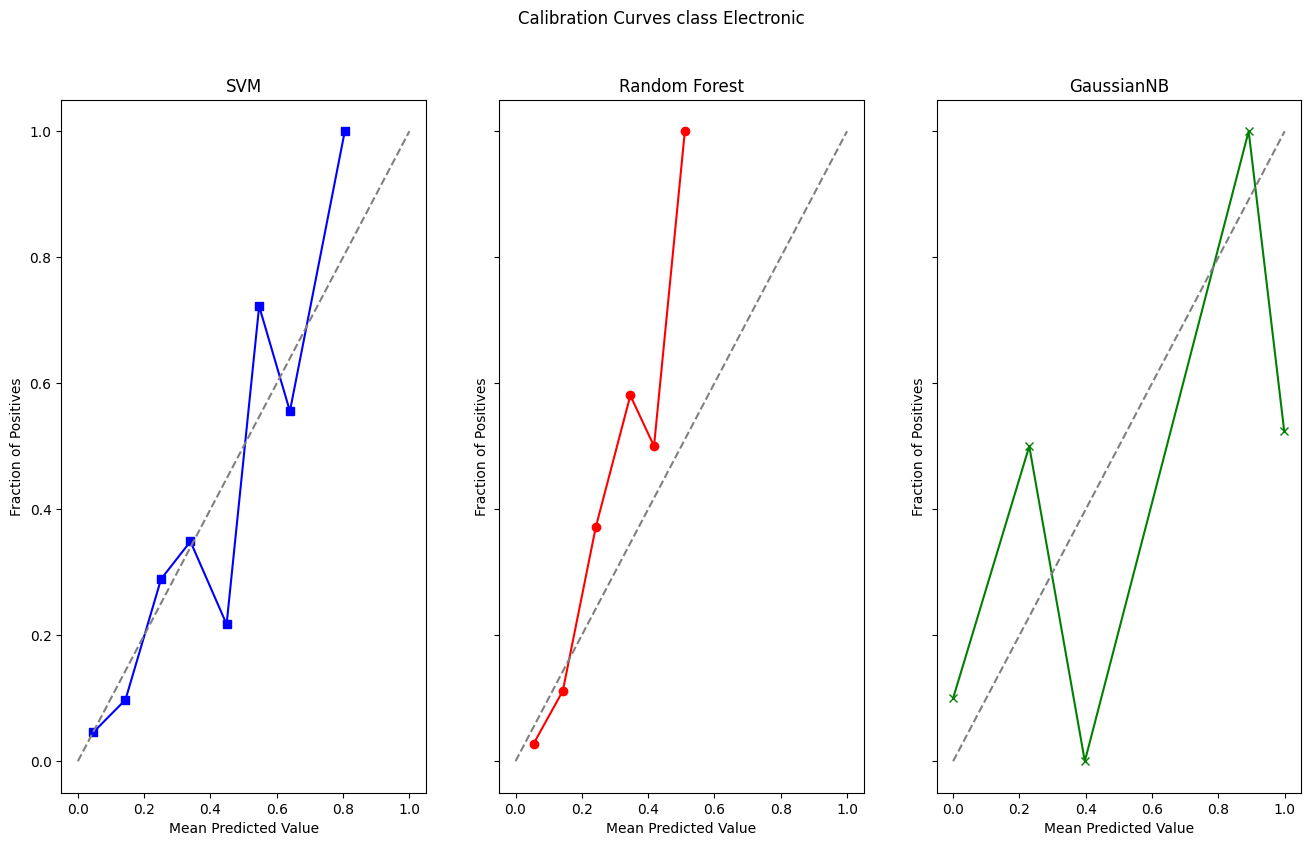

In [32]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

f, axarr = plt.subplots(1,3,figsize=(16, 9),sharex=True, sharey=True)

index_interess = 0
class_interess = clf.classes_[index_interess]

point = ['s-', 'o-', 'x-']
color = ["blue","red","green"]

plt.suptitle('Calibration Curves class {}'.format(class_interess))

for index_clf in range(len(all_classifier)):
    y_prob = all_classifier[index_clf].predict_proba(X_test)[:, index_interess]
    y_test_class = []

    #Isolo solo le predizioni della classe di interessa, ignoro le altre
    for value in y_test:
        if value == class_interess:
            y_test_class.append(1)
        else :
            y_test_class.append(0)

    prob_true1, prob_pred1 = calibration_curve(y_test_class, y_prob, n_bins=10)

    # Plotta le curve di calibrazione
    axarr[index_clf].plot(prob_pred1, prob_true1, point[index_clf], label=all_classifier_name[index_clf] , color=color[index_clf])
    axarr[index_clf].plot([0, 1], [0, 1], '--', color='gray', label='Perfectly calibrated')
    axarr[index_clf].set_xlabel('Mean Predicted Value')
    axarr[index_clf].set_ylabel('Fraction of Positives')
    axarr[index_clf].set_title(all_classifier_name[index_clf])




## Seconda sezione
Un suono può essere descritto attraverso la variazione di pressione dell'aria nel tempo.  Per rappresentare digitalmente un audio è necessario prelevare campioni della pressione al variare del tempo. La velocità con cui sono campionati i dati può variare in base al contesto, ma più comunemente è 44,1 kHz o 44.100 campioni al secondo. Quello che si cattura in questo modo è una forma d'onda, e questa può essere interpretata, modificata e analizzata con un software.

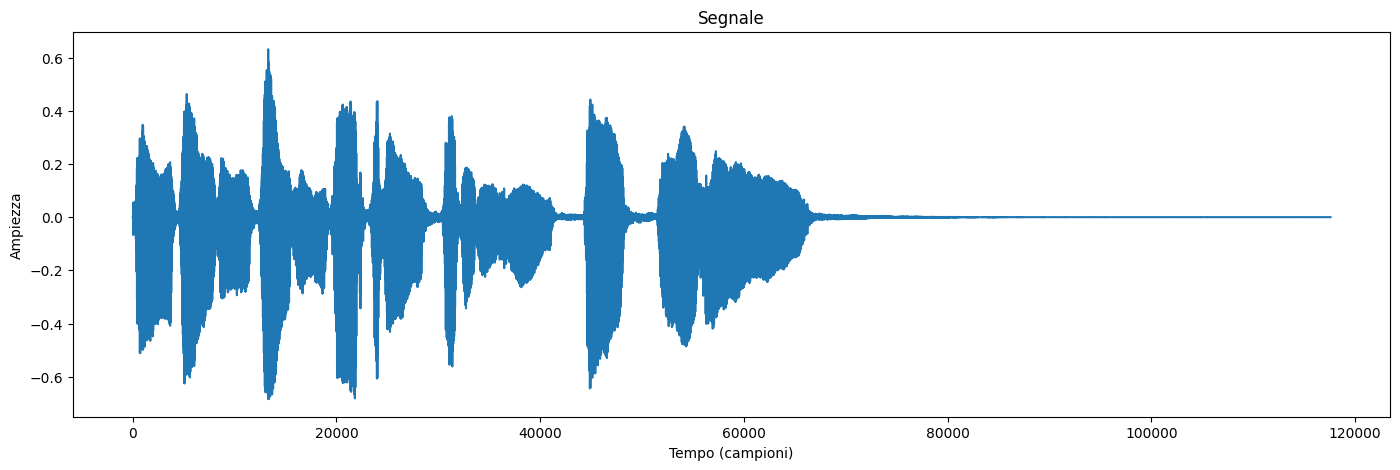

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
import librosa 
import librosa.display 

y, sr = librosa.load(librosa.ex('trumpet'))

plt.plot(y); 
plt.title('Segnale'); 
plt.xlabel('Tempo (campioni)'); 
plt.ylabel('Ampiezza');

Un segnale audio è composto da diverse onde sonore a singola frequenza che si sovrappongo tra loro. Quando si prende un campione del segnale nel tempo, si catturano solo le ampiezze risultanti della sovrapposizione. La trasformata di Fourier è una formula matematica che permette di scomporre un segnale nelle sue singole frequenze. In altre parole, converte il segnale dal dominio del tempo nel dominio della frequenza. Il risultato è chiamato spettro .

![1_xTYCtcx_7otHVu-uToI9dA.webp](https://miro.medium.com/v2/resize:fit:828/format:webp/1*xTYCtcx_7otHVu-uToI9dA.png)

Il codice seguente mostra la conversione di un segnale dal dominio del tempo a quello della frequenza.

Text(0, 0.5, 'Ampiezza')

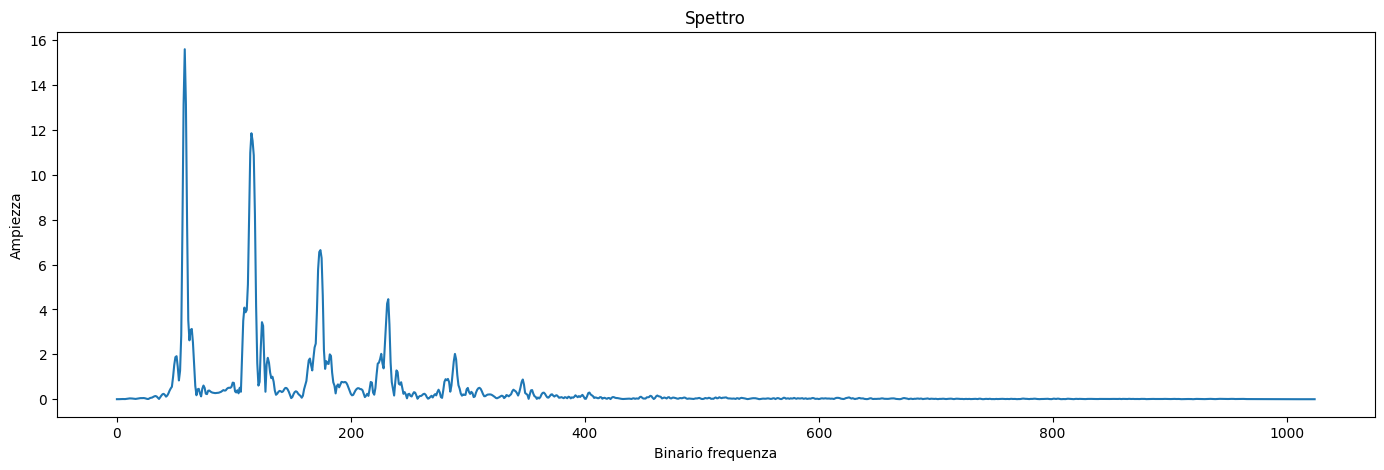

In [34]:
import numpy as np
n_fft = 2048 
ft = np.abs(librosa.stft(y[:n_fft], hop_length = n_fft+1))
plt.plot(ft); 
plt.title('Spettro')
plt.xlabel('Binario frequenza')
plt.ylabel('Ampiezza')

La trasformata veloce di Fourier è un potente strumento che consente di analizzare il contenuto in frequenza di un segnale, ma cosa succede se il contenuto in frequenza del nostro segnale varia nel tempo? Questo è il caso della maggior parte dei segnali audio come la musica e il parlato. Questi segnali sono noti come segnali non periodici . C'è bisogno di un modo per rappresentare lo spettro di questi segnali mentre variano nel tempo. Per fare questo è utilizzata la trasformata di Fourier di breve durata. La FFT viene calcolata sulla sovrapposizione di segmenti finestrati del segnale: quello che si ottiene viene chiamato spettrogramma.

![1_tIBRdtG3EfjmSIlraWVIxw.webp](https://miro.medium.com/v2/resize:fit:828/format:webp/1*tIBRdtG3EfjmSIlraWVIxw.png)

In un contetso di classificazione supervisionata di generi musicali,l'analisi dello spettrogramma potrebbe essere particolarmente utile per distinguere i vari generi. I dati offerti da FMA sono a tutti gli effetti statistiche come max, min e media calcolate a partire da una pre-elaborazione degli audio. Avere un'immagine che è più ricca e completa completa di una sequenza di statistiche potrebbe essere molto più utile a un classificatore.

Di seguito è riportato uno spettrogramma di un audio calcolatoto tramite la libreria librosa. L'idea è fornire in ingresso a un modello di classificazione proprio immagini di questo tipo.

Text(0.5, 1.0, 'Spettrogramma')

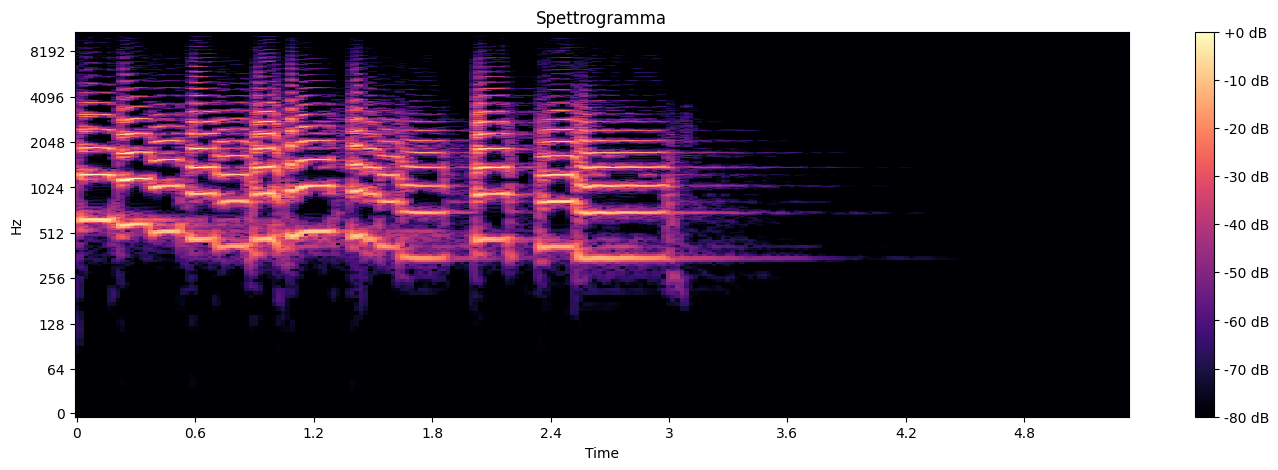

In [35]:
spec = np.abs(librosa.stft(y, hop_length=512)) 
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log') 
plt.colorbar(format='%+2.0f dB')
plt.title('Spettrogramma')

### CNN
Per l'addestramento di CNN l'idea è quella di dare in ingresso al modello di classificazione delle immagini generate a partire dagli spettrogrammi degli audio. L'idea si basa sul fatto che il dataset a disposizione contiene solo alcune statistiche descrittive, come media varianza moda. In questo modo con un immagine che descrive nel dettaglio la variazione di frequenza dell'audio potrebbe essere più semplice per un modello di predizione realizzare la classificazione. Si consideri inoltre che le reti convoluzionari funzionano molto bene nella classificazione di immagini. Il pezzo di codice seguente serve appunto per convertire un audio in uno settrogramma e salvarlo con un immagine a scala di grigi. 

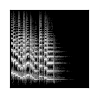

In [36]:
y, sr = librosa.load(librosa.ex('trumpet'))
librosa.feature.melspectrogram(y=y, sr=sr)
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)

fig, ax = plt.subplots()
fig.set_size_inches(1, 1)

S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, sr=sr,fmax=8000, ax=ax,cmap='gray')
plt.savefig("out.png",dpi=80,bbox_inches='tight', pad_inches=0)


Si ossercvi più nel dettaglio l'immagine generata. L'mmagine che è di 80 pixel*80 pixel. L'immagine è generata in modo che ad ogni pixel venga assegnato un numero in base alla gradazione della scala di grigi.

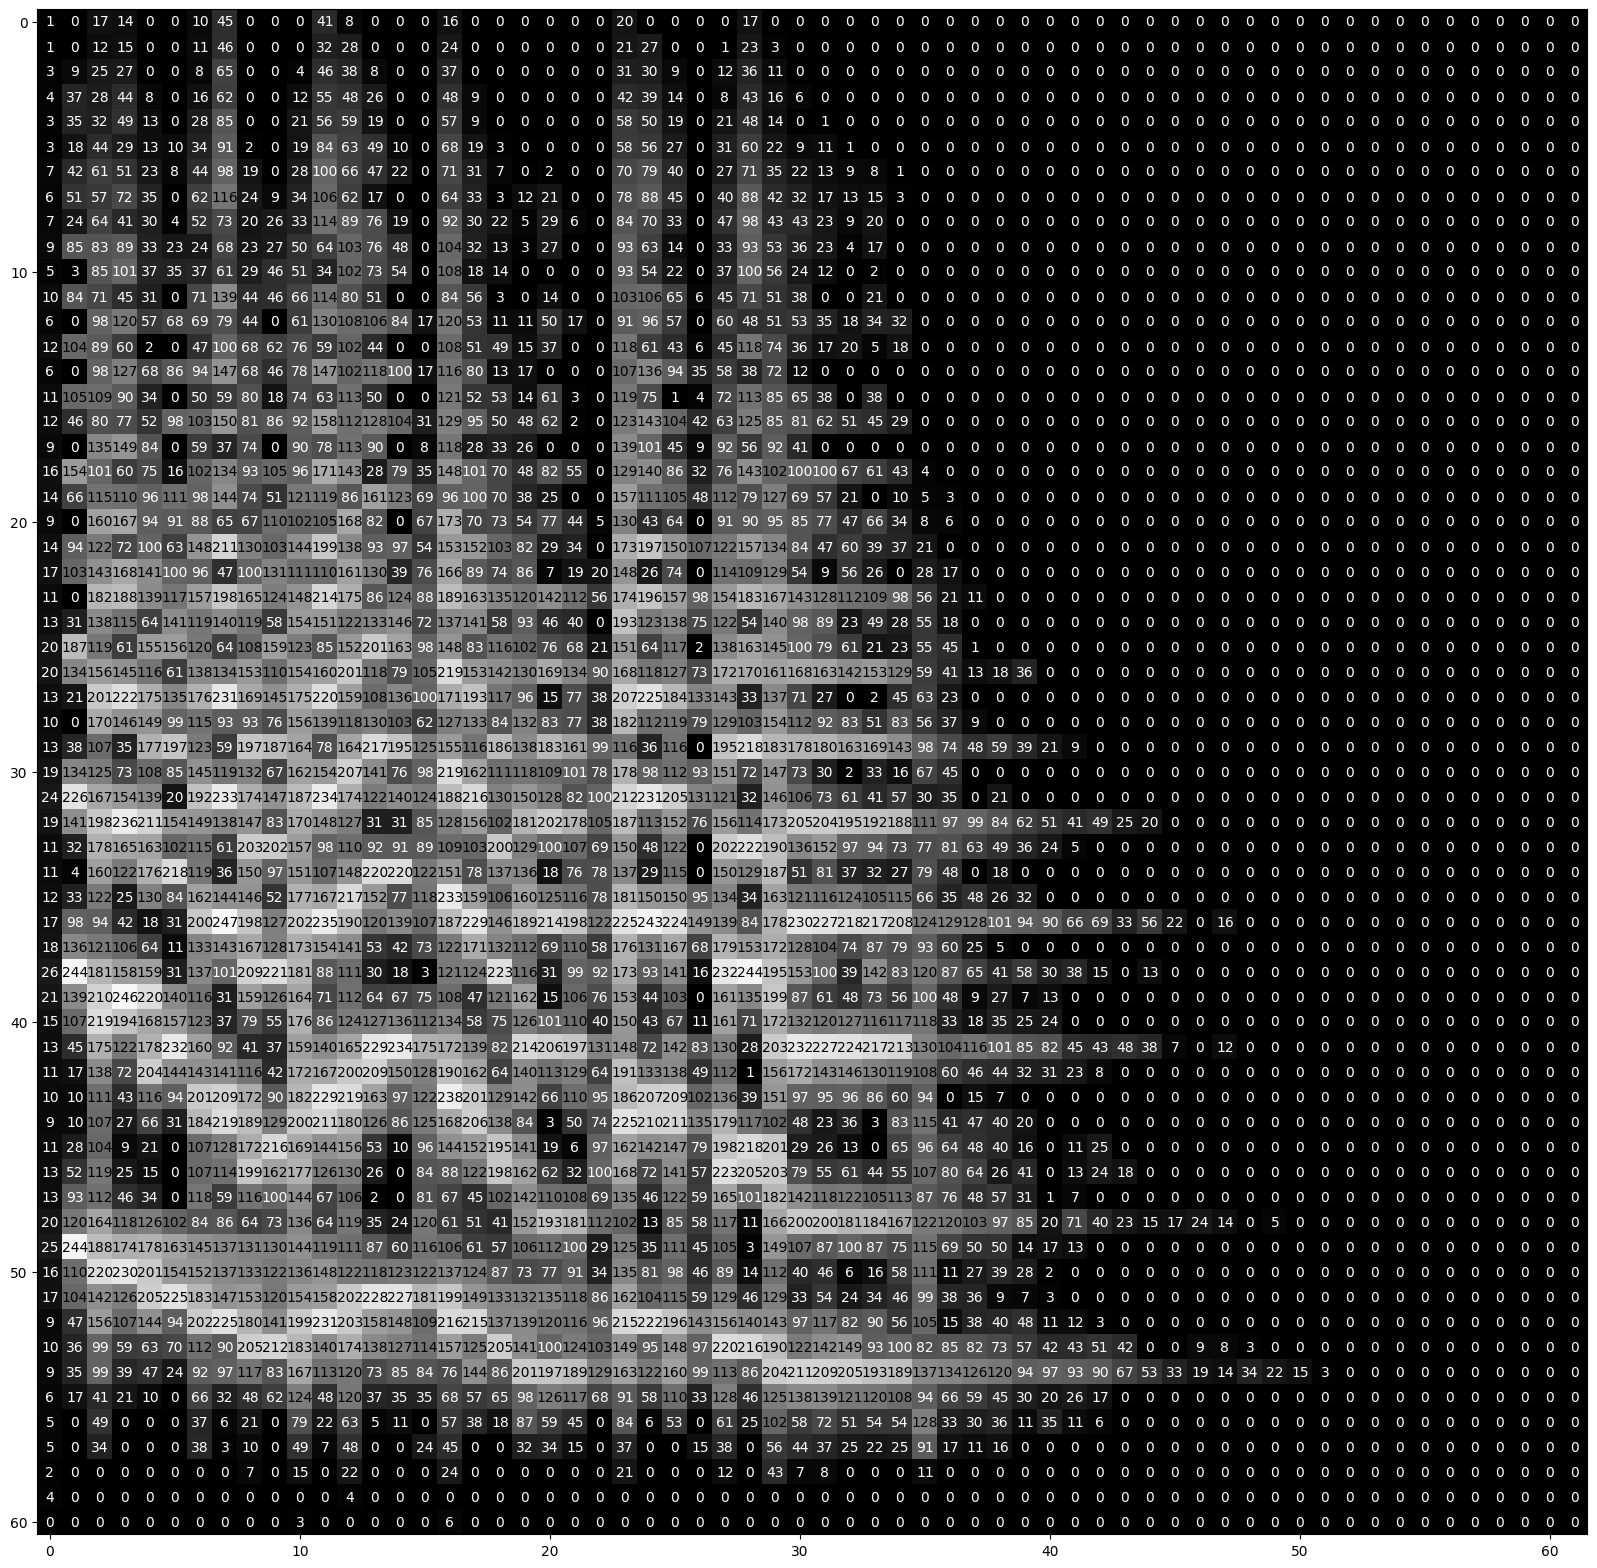

In [37]:
from PIL import Image
from numpy import array
im_1 = Image.open(r"out.png")
ar = array(im_1)
img = np.squeeze(ar)

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height,z = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = img[x][y][0] if img[x][y][0] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y][0]<thresh else 'black')

L'idea è quella di usare una rete convoluzionale. Le reti convoluzionali nei primi layer della rete effettuano una convoluzione. La convoluzione graficamente può essere vista come una sorta di filtro che permette di evidenziare o mascherare alcune caratteristiche dell'immagine. Nel codice seguente verranno applicati diversi filtri con l'obbiettivo di modificare l'immagine originale. Tutte le immagini modificate sono messe a confronto. Sono presi alcuni filtri comuni. Di questi solo il kernel blur sembra modificare in maniera "non distruttiva" l'immagine originale. Gli altri kernel modificano eccessivamente la struttura dell'immagine, rendendo probabilmente difficile la classificazione. Un breve descrizione dei kernel usati:
1. Kernel di sfocatura (Blur): Il kernel di sfocatura viene utilizzato per ridurre il rumore o per sfocare l'immagine. 
2. Kernel di rilevamento dei bordi (Edge detection): Il kernel di rilevamento dei bordi viene utilizzato per individuare i bordi o i contorni nell'immagine. 
3. Il kernel di sharpening (affilatura) viene utilizzato per accentuare i dettagli e i bordi delle immagini. Questo tipo di kernel crea un effetto di contrasto aumentato tra i pixel adiacenti, rendendo i bordi più nitidi.
4. Il kernel di Laplace, noto anche come kernel del secondo ordine o kernel del laplaciano, è un kernel utilizzato per il rilevamento delle discontinuità di intensità in un'immagine. Può essere usato per individuare bordi, linee o punti di interesse nell'immagine.
5. Il kernel gaussiano viene applicato  per calcolare il valore di un pixel nell'immagine di output come la media pesata dei pixel nell'area circostante, dove i pesi sono determinati dal kernel gaussiano. Ciò porta a uno sfocatura graduale dell'immagine, in cui i pixel vicini contribuiscono maggiormente al valore del pixel risultante.
6. Il kernel orizzontale evidenzia i bordi orizzontali dell'immagine.
7. Il kernel verticale evidenzia i bordi verticali dell'immagine.

L'idea in questo caso è che ogni colore dell'immagine associato alla posizione identifica un particolare contributo di frequenza. Di conseguenza applicando il filtro è possibile mascherare o mettere maggiormente in evidenza dei pixel(quindi delle frequenze) che permettono di descrivere in maniera ottimale l'immagine e migliorare le prestazioni di classificazione.

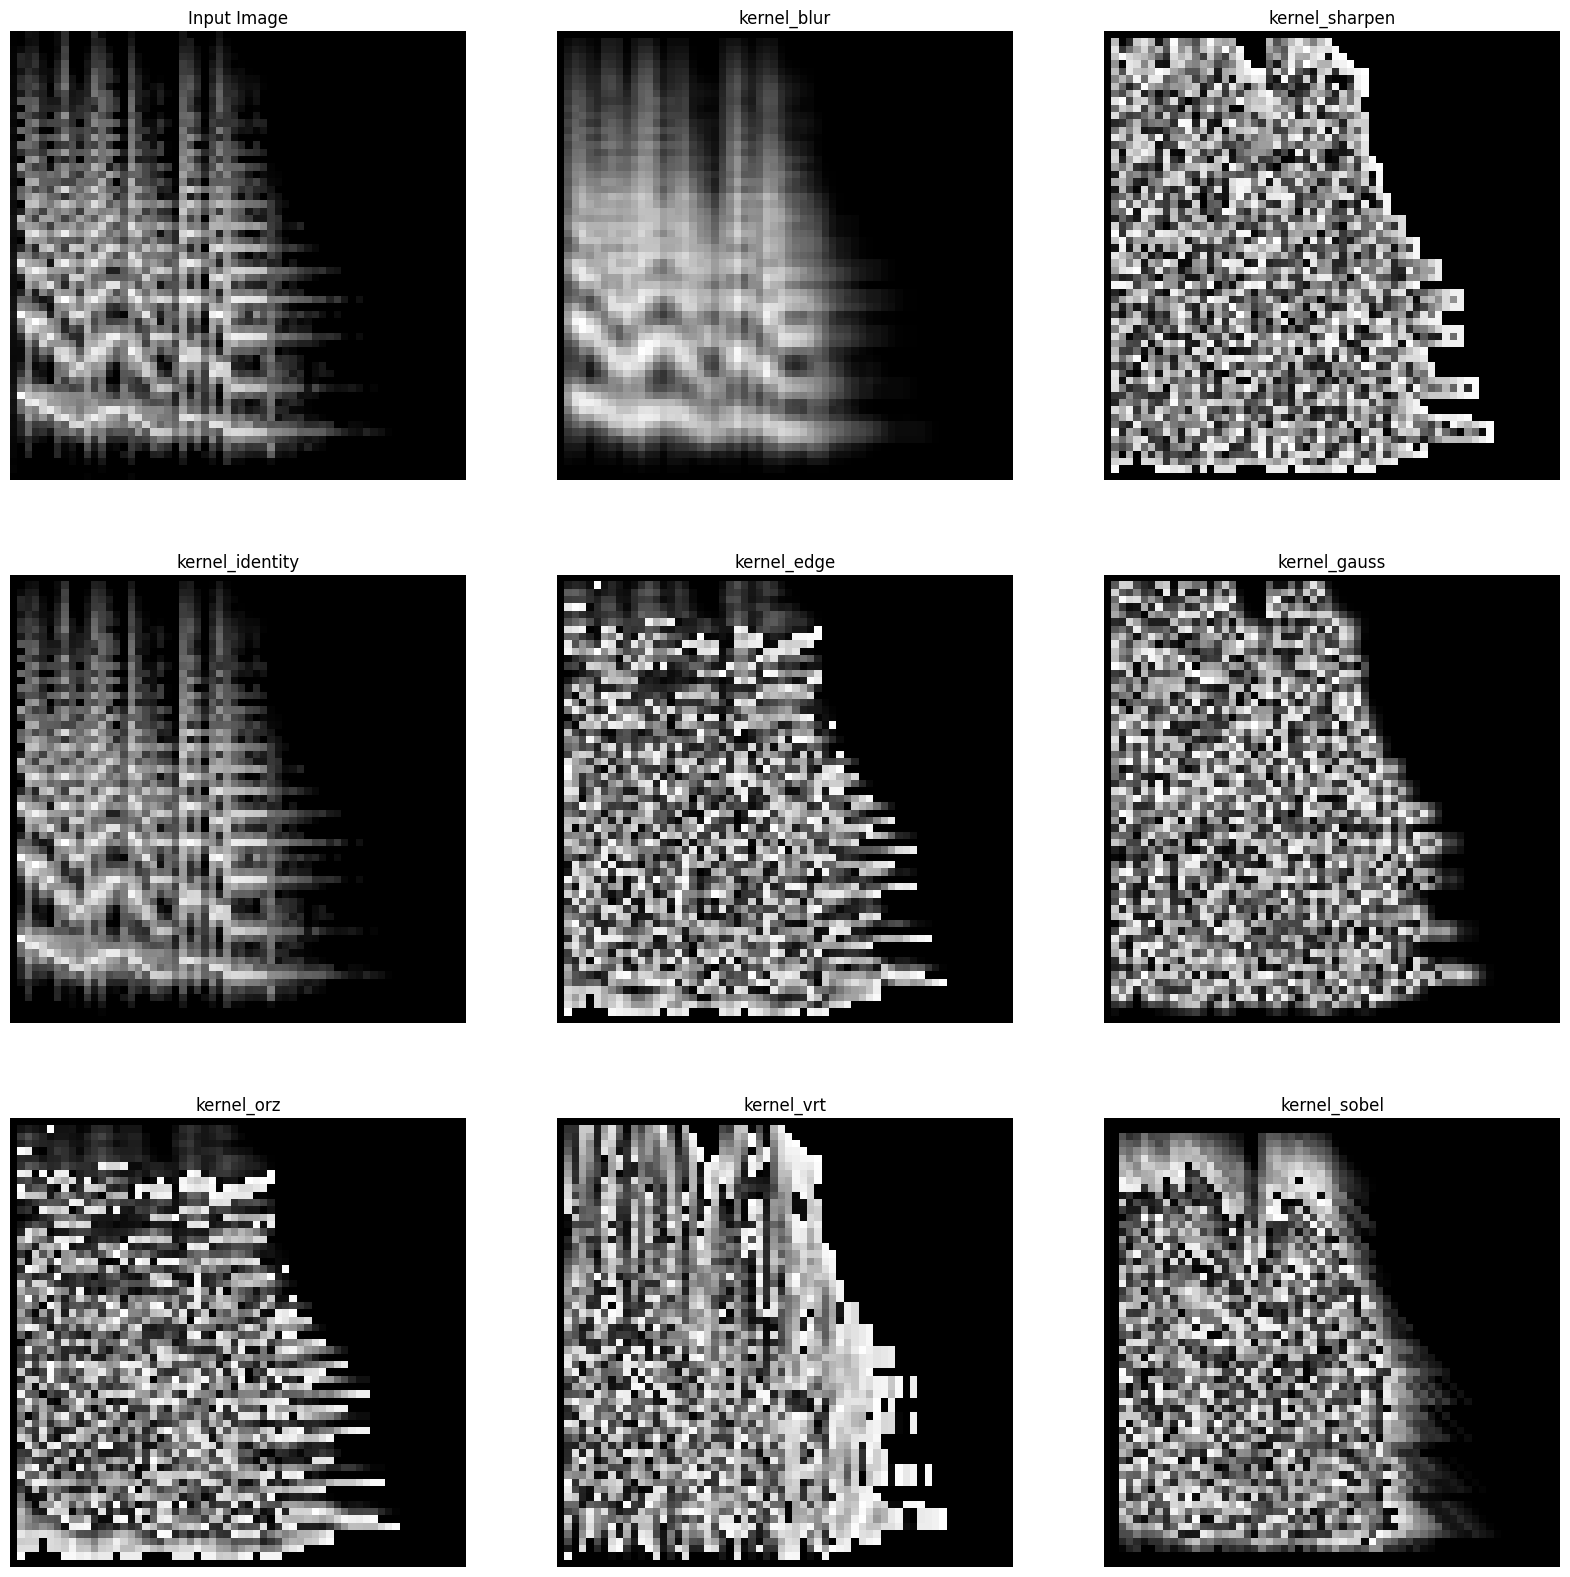

In [38]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Carica l'immagine
img = Image.open(r"out.png")

# Converto l'immagine in scala di grigi
gray_img = img.convert("L")

# Converto l'immagine in un array NumPy
image_array = np.array(gray_img)

all_kernel=[]
all_kernel_name=[]

# Definizione vari kernel
kernel_identity = np.array([[0, 0, 0],[0, 1, 0],[0, 0, 0]])
kernel_blur= np.array([[1/9, 1/9, 1/9],[1/9, 1/9, 1/9],[1/9, 1/9, 1/9]])
kernel_edge = np.array([[-1, -2, -1],[ 0,  0,  0],[ 1,  2,  1]])
kernel_sharpen = np.array([[-1, -1, -1],[-1,  9, -1],[-1, -1, -1]])
kernel_laplace = np.array([[ 0, -1,  0],[-1,  4, -1], [ 0, -1,  0]])
kernel_gauss = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])
kernel_orz = np.array([[-1, -1, -1],[ 0,  0,  0],[ 1,  1,  1]])
kernel_vrt = np.array([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]])
kernel_sobel = np.array([[1, 0, 0, 0, 0],[0, 1, 0, 0, 0],[0, 0, 1, 0, 0],[0, 0, 0, 1, 0],[0, 0, 0, 0, 1]])

all_kernel.append(kernel_identity)
all_kernel.append(kernel_blur)
all_kernel.append(kernel_edge)
all_kernel.append(kernel_sharpen)
all_kernel.append(kernel_gauss)
all_kernel.append(kernel_orz)
all_kernel.append(kernel_vrt)
all_kernel.append(kernel_sobel)

all_kernel_name.append("kernel_identity")
all_kernel_name.append("kernel_blur")
all_kernel_name.append("kernel_edge")
all_kernel_name.append("kernel_sharpen")
all_kernel_name.append("kernel_gauss")
all_kernel_name.append("kernel_orz")
all_kernel_name.append("kernel_vrt")
all_kernel_name.append("kernel_sobel")

f, axarr = plt.subplots(3,3,figsize=(20, 20),sharex=True, sharey=True)
all_pos_to_plot = [[1,0],[0,1],[1,1],[0,2],[1,2],[2,0],[2,1],[2,2]]

axarr[0][0].imshow(gray_img, cmap="gray")
axarr[0][0].set_title("Input Image")
axarr[0][0].axis("off")

for id_kernel,kernel in enumerate(all_kernel):

    output_array = np.zeros_like(image_array)
    image_height = image_array.shape[0]
    image_width = image_array.shape[1]
    kernel_height, kernel_width = kernel.shape
    padding_height = kernel_height // 2
    padding_width = kernel_width // 2

    # Applica la convoluzione
    for i in range(padding_height, image_height - padding_height):
        for j in range(padding_width, image_width - padding_width):
            window = image_array[i - padding_height:i + padding_height + 1,
                                j - padding_width:j + padding_width + 1]
            output_array[i, j] = np.sum(window * kernel)

    # Crea l'immagine di output
    output_image = Image.fromarray(output_array.astype(np.uint8))

    pos_to_plot = all_pos_to_plot[id_kernel]

    # Visualizza l'immagine di input e di output
    axarr[pos_to_plot[0]][pos_to_plot[1]].imshow(output_image, cmap="gray")
    axarr[pos_to_plot[0]][pos_to_plot[1]].set_title(all_kernel_name[id_kernel])
    axarr[pos_to_plot[0]][pos_to_plot[1]].axis("off")
    
plt.show()


Terminato questo breve confronto è possibile definire una rete convoluzionale. Questa rete specifica avrà 2 layer convoluzionali e 2 layer full connected . E' previsto un metodo per modificare il primo layer convoluzionale per testare i vari filtri definiti nel pezzo di codice precedente.

In [51]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Definizione dei livelli convoluzionali
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calcolo delle dimensioni dell'output dopo i livelli convoluzionali
        self.flat_size = 32 * 7 * 7
        
        # Livelli fully connected
        self.fc1 = nn.Linear(self.flat_size, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 8)
    
    def forward(self, x):
        # Passaggio dei dati attraverso i livelli convoluzionali
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        # Flattening dell'output per i livelli fully connected
        x = x.view(-1, self.flat_size)
        
        # Passaggio attraverso i livelli fully connected
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

    def set_weight_conv1(self,kernel):
        tensor = []

        for i in range(16):

            tensor_x=[]
            for j in range(4):

                tensor_x.append(kernel)

            tensor.append(tensor_x)

        valori = torch.tensor(tensor,dtype=torch.float)
        self.conv1.weight = nn.Parameter(valori)



Si definiscono le funzioni per addestrare la rete e per testarla.

In [56]:
from sklearn.preprocessing import LabelEncoder
from torch import optim

num_epochs = 10

def train(num_epochs, cnn, train_loader):
    
  optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   

  #Utilizzo cuda se disponibile
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  cnn.to(device)
  cnn.train()
  
  loss_func = nn.CrossEntropyLoss()
  optimizer = optim.Adam(cnn.parameters(), lr=0.001)
      
  for epoch in range(num_epochs):
    for images, labels in train_loader:
      
      labels = torch.tensor(labels).to(device)
      images = images.to(device)
      
      outputs = cnn(images)
      loss = loss_func(outputs, labels)
      
      optimizer.zero_grad()           
      loss.backward()    
      optimizer.step()  

                      
      

In [53]:
def test(model, dataloader):
    # Impostazione del modello in modalità valutazione
    model.eval()  
    
    corretti = 0
    totali = 0
    
    with torch.no_grad():
        for immagini, etichette in dataloader:
           
            output = model(immagini)
            _, predizioni = torch.max(output, 1)
            
            totali +=len(etichette)

            for i in range(len(predizioni)):
                if(predizioni[i]==etichette[i]):
                    corretti=corretti+1

    
    accuratezza = 100.0 * corretti / totali
    return accuratezza

Una volta definita la rete , il metodo di test e train è possibile addestrare la rete nel concreto. Per farla prima si costrisce un dataset a partire dalle immagini che sono state generate dagli audio. Si può osservare come si ottenga un accuratezza del 60% , valore migliore rispetto agli altri modelli di classificazione addestrati in precedenza.

In [62]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class MyCustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

# Carica il training set dal file npz
dataset_imm = np.load("training\\training_set.npz")
imgs = dataset_imm["immagini"]
labels = dataset_imm["etichette"]

# Crea un oggetto LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Crea una trasformazione ToTensor
transform = transforms.ToTensor()

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2, random_state=42)

#Creo dataset
dataset_train = MyCustomDataset(X_train, y_train,transform)
dataset_test = MyCustomDataset(X_test, y_test,transform)

# Crea un DataLoader per il dataset di addestramento
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

#Addestro e testo
cnn = CNN()
train(40,cnn,train_loader)
test(cnn,test_loader)

60.215053763440864

Infine si procede a cambiare il primo layer convoluzionale considerando i kernel definiti in precedenza e riaddestrare i modelli.

In [61]:

for idx,kernel in enumerate(all_kernel):
    cnn = CNN()
    cnn.set_weight_conv1(kernel)
    train(10,cnn,train_loader)
    acc = test(cnn,test_loader)

    print("{}:{}".format(all_kernel_name[idx],acc))

kernel_identity:40.86021505376344
kernel_blur:41.935483870967744
kernel_edge:54.83870967741935
kernel_sharpen:48.38709677419355
kernel_gauss:24.731182795698924
kernel_orz:47.31182795698925
kernel_vrt:44.086021505376344
kernel_sobel:26.881720430107528
